In [1]:
import anndata
import torch
import stPlus

import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd
import spatialdm as sdm

from sklearn.model_selection import KFold
from transpa.eval_util import calc_corr
from transpa.util import expTransImp, leiden_cluster, compute_autocorr
from benchmark import SpaGE_impute, Tangram_impute
import warnings

warnings.filterwarnings('ignore')
spec = "mouse"
ST_name = "mouseliver5fold"
seed = 10
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
samples = ['c1']
rna_adata = anndata.concat(
    [sc.read_csv(f"../../data/scRNAseq/MouseLiver/SCP2045/expression/processed_{sub}.csv.gz").T.copy() for sub in samples], join="inner")
rna_adata.obs = pd.read_csv("../../data/scRNAseq/MouseLiver/SCP2045/metadata/meta_data_manual.csv", index_col=0).loc[rna_adata.obs_names]
rna_adata.obsm['X_umap'] = pd.read_csv("../../data/scRNAseq/MouseLiver/SCP2045/cluster/clustering_manual.csv", index_col=0).loc[rna_adata.obs_names][["X", "Y"]].values.astype(np.float32)
rna_adata.obs['celltype'] = pd.read_csv("../../data/scRNAseq/MouseLiver/SCP2045/cluster/clustering_manual.csv", index_col=0).loc[rna_adata.obs_names]["Category"].values


spa_adata = anndata.concat(
    [sc.read_csv(f"../../data/ST/MouseLiver/SCP2046/expression/processed_{sub}.csv.gz").T.copy() for sub in samples], join="inner")
spa_adata.obs = pd.read_csv("../../data/ST/MouseLiver/SCP2046/metadata/meta_data.csv", index_col=0).loc[spa_adata.obs_names]
spa_adata.obsm['X_umap'] = pd.read_csv("../../data/ST/MouseLiver/SCP2046/cluster/clustering.csv", index_col=0).loc[spa_adata.obs_names][["X", "Y"]].values.astype(np.float32)
spa_adata.obs['celltype'] = pd.read_csv("../../data/ST/MouseLiver/SCP2046/cluster/clustering.csv", index_col=0).loc[spa_adata.obs_names]["Category"].values
spa_adata.obsm['spatial'] = pd.concat([pd.read_csv(f"../../data/ST/MouseLiver/SCP2046/cluster/spatial_{sb}.csv", index_col=0).iloc[1:] for sb in samples], axis=0).loc[spa_adata.obs_names].values.astype(np.float32)
pd.DataFrame(spa_adata.obsm['spatial'], columns=['x','y']).to_csv(f"../../output/locations/{ST_name}.csv", index=False)

rna_adata, spa_adata

(AnnData object with n_obs × n_vars = 4759 × 19355
     obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'celltype'
     obsm: 'X_umap',
 AnnData object with n_obs × n_vars = 2110 × 16225
     obs: 'biosample_id', 'zones', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'celltype'
     obsm: 'X_umap', 'spatial')

In [3]:
classes, ct_list = leiden_cluster(rna_adata, False)
cls_key = 'leiden'
rna_adata.obs[cls_key] = classes
sq.gr.spatial_neighbors(spa_adata, coord_type="grid", n_neighs=6)
sq.gr.spatial_autocorr(
    spa_adata,
    n_jobs=10,
)

sc.pp.filter_genes(rna_adata, min_cells=10)
sc.pp.filter_genes(spa_adata, min_cells=3)
# sc.pp.highly_variable_genes(rna_adata, n_top_genes=10000)
# rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
sdm.extract_lr(spa_adata, spec, min_cell=0)
spa_genes = set()
for pair in spa_adata.uns['geneInter'].interaction_name:
    _genes = pair.split('_')
    for g in _genes:
        for _g in g.split(":"):
            spa_genes.add(_g)
for gene in spa_adata.uns['moranI'].index[spa_adata.uns['moranI'].I >= 0].values:
    spa_genes.add(gene)
sc.pp.highly_variable_genes(spa_adata, n_top_genes=5000)
for gene in spa_adata.var_names[spa_adata.var.highly_variable]:    
    spa_genes.add(gene)    
    
print(len(np.intersect1d(list(spa_genes), spa_adata.var_names)), len(spa_genes), spa_adata.n_vars)
spa_adata = spa_adata[:, np.intersect1d(list(spa_genes), spa_adata.var_names)]
rna_adata, spa_adata

12307 12871 15822


(AnnData object with n_obs × n_vars = 4759 × 15521
     obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'celltype', 'leiden'
     var: 'n_cells'
     obsm: 'X_umap',
 View of AnnData object with n_obs × n_vars = 2110 × 12307
     obs: 'biosample_id', 'zones', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'celltype'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'spatial_neighbors', 'moranI', 'mean', 'ligand', 'receptor', 'num_pairs', 'geneInter', 'hvg'
     obsm: 'X_umap', 'spatial'
     obsp: 'spatial_connectivities', 'spatial_distances')

In [4]:
raw_spatial_df  = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)
raw_scrna_df    = pd.DataFrame(rna_adata.X, columns=rna_adata.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((2110, 12307), (4759, 15521), (11365,))

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(raw_shared_gene)

df_transImpSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpCls = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpClsSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImp = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_stplus_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_spaGE_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_tangram_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)

for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):    
    print(f"\n===== Fold {idx+1} =====\nNumber of train genes: {len(train_ind)}, Number of test genes: {len(test_ind)}")
    train_gene = raw_shared_gene[train_ind]
    test_gene  = raw_shared_gene[test_ind]
    
    test_spatial_df = raw_spatial_df[test_gene]
    spatial_df = raw_spatial_df[train_gene]
    scrna_df   = raw_scrna_df

    df_transImpSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        n_epochs=2000,
        mapping_mode='lowrank',
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        seed=seed,
        device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpSpa)')

    df_transImpCls[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                ct_list=ct_list,
                classes=classes,
                signature_mode='cluster',
                mapping_mode='full',
                n_epochs=2000,
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpCls)')

    df_transImp[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                signature_mode='cell',
                mapping_mode='lowrank',
                n_epochs=2000,
                seed=seed,
                device=device)
    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImp)')

    df_transImpClsSpa[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                ct_list=ct_list,
                classes=classes,
                spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
                signature_mode='cluster',
                mapping_mode='full',
                n_epochs=2000,
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpClsSpa)')

    df_stplus_res[test_gene] = stPlus.stPlus(spatial_df, scrna_df, test_gene, "464", top_k=2000, verbose=False, random_seed=seed, device=device)
    corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_stplus)} (stPlus)')

    df_spaGE_res[test_gene]  = SpaGE_impute(scrna_df, spatial_df, train_gene, test_gene)
    corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_spaGE)} (spaGE)')

    df_tangram_res[test_gene] = Tangram_impute(rna_adata, spa_adata, train_gene, test_gene, device, cls_key)
    corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_tangram)} (Tangram)')

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, raw_shared_gene)
corr_transImp_res = calc_corr(raw_spatial_df, df_transImp, raw_shared_gene)
corr_transImpCls_res = calc_corr(raw_spatial_df, df_transImpCls, raw_shared_gene)
corr_transImpClsSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, raw_shared_gene)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, raw_shared_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, raw_shared_gene)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, raw_shared_gene)   

print(np.median(corr_transImpSpa_res), "(TransImpSpa)", 
      np.median(corr_transImp_res), "(TransImp)", 
      np.median(corr_transImpCls_res), "(TransImpCls)", 
      np.median(corr_transImpClsSpa_res), "(TransImpClsSpa)", 
      np.median(corr_res_stplus), "(stPlus)", 
      np.median(corr_res_spaGE), "(spaGE)",
      np.median(corr_res_tangram), "(Tangram)"
      )


===== Fold 1 =====
Number of train genes: 9092, Number of test genes: 2273


[TransImp] Epoch: 2000/2000, loss: 0.612911, (IMP) 0.611466, (SPA) 1.0 x 0.001446: 100%|██████████| 2000/2000 [00:38<00:00, 51.58it/s]


Median correlation: 0.10653677571516373 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.694238, (IMP) 0.694238, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:15<00:00, 131.18it/s]


Median correlation: 0.13331148407231375 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.608722, (IMP) 0.608722, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:25<00:00, 78.39it/s]


Median correlation: 0.12066731442349392 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 0.697025, (IMP) 0.695296, (SPA) 1.0 x 0.001729: 100%|██████████| 2000/2000 [00:28<00:00, 70.04it/s]


Median correlation: 0.12237074614840825 (TransImpClsSpa)
			nan (stPlus)
			0.08805726299852992 (spaGE)


INFO:root:9092 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:9092 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 9092 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.490, KL reg: 0.057
Score: 0.566, KL reg: 0.000
Score: 0.566, KL reg: 0.000
Score: 0.566, KL reg: 0.000
Score: 0.566, KL reg: 0.000
Score: 0.567, KL reg: 0.000
Score: 0.567, KL reg: 0.000
Score: 0.567, KL reg: 0.000
Score: 0.567, KL reg: 0.000
Score: 0.567, KL reg: 0.000


INFO:root:Saving results..


			0.12716210553504306 (Tangram)

===== Fold 2 =====
Number of train genes: 9092, Number of test genes: 2273


[TransImp] Epoch: 2000/2000, loss: 0.612337, (IMP) 0.610859, (SPA) 1.0 x 0.001477: 100%|██████████| 2000/2000 [00:38<00:00, 52.54it/s]


Median correlation: 0.1093039336289251 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.693836, (IMP) 0.693836, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:15<00:00, 130.85it/s]


Median correlation: 0.13386300066545154 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.608110, (IMP) 0.608110, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:25<00:00, 78.41it/s]


Median correlation: 0.12143366050956979 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 0.696653, (IMP) 0.694903, (SPA) 1.0 x 0.001750: 100%|██████████| 2000/2000 [00:28<00:00, 71.35it/s]


Median correlation: 0.1220101599692291 (TransImpClsSpa)
			nan (stPlus)
			0.08750168479528801 (spaGE)


INFO:root:9092 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:9092 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 9092 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.491, KL reg: 0.057
Score: 0.567, KL reg: 0.000
Score: 0.567, KL reg: 0.000
Score: 0.567, KL reg: 0.000
Score: 0.567, KL reg: 0.000
Score: 0.567, KL reg: 0.000
Score: 0.567, KL reg: 0.000
Score: 0.567, KL reg: 0.000
Score: 0.567, KL reg: 0.000
Score: 0.567, KL reg: 0.000


INFO:root:Saving results..


			0.12713324156943973 (Tangram)

===== Fold 3 =====
Number of train genes: 9092, Number of test genes: 2273


[TransImp] Epoch: 2000/2000, loss: 0.609776, (IMP) 0.608377, (SPA) 1.0 x 0.001399: 100%|██████████| 2000/2000 [00:37<00:00, 52.73it/s]


Median correlation: 0.10602955105056719 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.692850, (IMP) 0.692850, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:15<00:00, 131.30it/s]


Median correlation: 0.13434185451195343 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.605417, (IMP) 0.605417, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:25<00:00, 79.22it/s]


Median correlation: 0.12290261135013925 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 0.695632, (IMP) 0.693880, (SPA) 1.0 x 0.001752: 100%|██████████| 2000/2000 [00:28<00:00, 71.31it/s]


Median correlation: 0.12517405236498788 (TransImpClsSpa)
			nan (stPlus)
			0.08796782474362075 (spaGE)


INFO:root:9092 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:9092 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 9092 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.492, KL reg: 0.057
Score: 0.568, KL reg: 0.000
Score: 0.569, KL reg: 0.000
Score: 0.569, KL reg: 0.000
Score: 0.569, KL reg: 0.000
Score: 0.569, KL reg: 0.000
Score: 0.569, KL reg: 0.000
Score: 0.569, KL reg: 0.000
Score: 0.569, KL reg: 0.000
Score: 0.569, KL reg: 0.000


INFO:root:Saving results..


			0.12918320412831816 (Tangram)

===== Fold 4 =====
Number of train genes: 9092, Number of test genes: 2273


[TransImp] Epoch: 2000/2000, loss: 0.619733, (IMP) 0.618374, (SPA) 1.0 x 0.001359: 100%|██████████| 2000/2000 [00:38<00:00, 51.75it/s]


Median correlation: 0.1102614797519152 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.700563, (IMP) 0.700563, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:15<00:00, 130.90it/s]


Median correlation: 0.13409963007615158 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.615386, (IMP) 0.615386, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:25<00:00, 78.65it/s]


Median correlation: 0.12217300859917782 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 0.703186, (IMP) 0.701605, (SPA) 1.0 x 0.001581: 100%|██████████| 2000/2000 [00:27<00:00, 71.86it/s]


Median correlation: 0.12306694038150677 (TransImpClsSpa)
			nan (stPlus)
			0.08969879475506003 (spaGE)


INFO:root:9092 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:9092 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 9092 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.490, KL reg: 0.057
Score: 0.566, KL reg: 0.000
Score: 0.566, KL reg: 0.000
Score: 0.566, KL reg: 0.000
Score: 0.566, KL reg: 0.000
Score: 0.566, KL reg: 0.000
Score: 0.566, KL reg: 0.000
Score: 0.566, KL reg: 0.000
Score: 0.566, KL reg: 0.000
Score: 0.566, KL reg: 0.000


INFO:root:Saving results..


			0.1277335291174201 (Tangram)

===== Fold 5 =====
Number of train genes: 9092, Number of test genes: 2273


[TransImp] Epoch: 2000/2000, loss: 0.619011, (IMP) 0.617615, (SPA) 1.0 x 0.001396: 100%|██████████| 2000/2000 [00:38<00:00, 52.43it/s]


Median correlation: 0.10650550575648446 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.697418, (IMP) 0.697418, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:15<00:00, 129.59it/s]


Median correlation: 0.13657111365119246 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.614427, (IMP) 0.614427, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:25<00:00, 77.66it/s]


Median correlation: 0.12253942425771944 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 0.700045, (IMP) 0.698452, (SPA) 1.0 x 0.001593: 100%|██████████| 2000/2000 [00:28<00:00, 70.59it/s]


Median correlation: 0.12494692323239258 (TransImpClsSpa)
			nan (stPlus)
			0.09028297567447076 (spaGE)


INFO:root:9092 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:9092 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 9092 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.492, KL reg: 0.057
Score: 0.568, KL reg: 0.000
Score: 0.568, KL reg: 0.000
Score: 0.568, KL reg: 0.000
Score: 0.568, KL reg: 0.000
Score: 0.568, KL reg: 0.000
Score: 0.568, KL reg: 0.000
Score: 0.568, KL reg: 0.000
Score: 0.568, KL reg: 0.000
Score: 0.568, KL reg: 0.000


INFO:root:Saving results..


			0.12934745369928208 (Tangram)
0.10763189797882072 (TransImpSpa) 0.12187463717858726 (TransImp) 0.13446129129601755 (TransImpCls) 0.12349445502842592 (TransImpClsSpa) nan (stPlus) 0.08861865244747669 (spaGE) 0.1281099796586762 (Tangram)


In [6]:
df_transImp.to_csv(f'../../output/{ST_name}_{ST_name}_TransImp.csv')
df_transImpSpa.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpSpa.csv')
df_transImpCls.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpCls.csv')
df_transImpClsSpa.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpClsSpa.csv')
df_spaGE_res.to_csv(f'../../output/{ST_name}_{ST_name}_spaGE.csv')
df_stplus_res.to_csv(f'../../output/{ST_name}_{ST_name}_stPlus.csv')
df_tangram_res.to_csv(f'../../output/{ST_name}_{ST_name}_Tangram.csv')
raw_spatial_df[raw_shared_gene].to_csv(f'../../output/{ST_name}_{ST_name}_truth.csv')


In [7]:
dict_df = {
            "TransImp":df_transImp, 
           "TransImpSpa":df_transImpSpa, 
           "TransImpCls":df_transImpCls,
           "TransImpClsSpa":df_transImpClsSpa,
           "spaGE": df_spaGE_res, 
           "stPlus": df_stplus_res,
            "Tangram":df_tangram_res,
            "truth":raw_spatial_df[raw_shared_gene].copy(),
            }
spa_adata.X = spa_adata.X.toarray()
sq.gr.spatial_autocorr(
    spa_adata,
    genes=spa_adata.var_names,
    n_jobs=10,
)

dict_adata = {name: compute_autocorr(spa_adata[:, raw_shared_gene].copy(), df) for name, df in dict_df.items()}


In [8]:
from sklearn.metrics import mean_squared_error
moranIs = {name:mean_squared_error(spa_adata.uns['moranI'].loc[raw_shared_gene].I, imp_adata.uns['moranI'].loc[raw_shared_gene].I) for name, imp_adata in dict_adata.items() if name != 'stPlus'}

print("Mean Squared Error\nMoran's I:\n")
print("\n".join([f"\tTrue vs {method}: {score:.6f}" for method, score in moranIs.items()]))



Mean Squared Error
Moran's I:

	True vs TransImp: 0.110063
	True vs TransImpSpa: 0.001969
	True vs TransImpCls: 0.114212
	True vs TransImpClsSpa: 0.002094
	True vs spaGE: 0.025600
	True vs Tangram: 0.098372
	True vs truth: 0.000000


In [9]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import seaborn as sns
import os
import torch
import pickle


from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import warnings

color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
methods = ['truth', 'Tangram', 'TransImp', 'TransImpSpa', 'spaGE', 'stPlus',  'TransImpCls', 'TransImpClsSpa']
warnings.filterwarnings('ignore')

eval_res_path = f"../../output/{ST_name}ext_small_train_eval_results.pkl"
is_reeval = True

seed = 10
thred = 0.01

In [10]:
if is_reeval:
    df_spa = dict_df['truth']
    imp_adatas = {}
    eval_res = {'se_moranI':{}, 'pred_corr':{}, 'fdr':{}, 'I':{}, 'pval':{}}
    for method  in tqdm(methods):
        
        imp_adata = dict_adata[method]
        df_res = dict_df[method]
        corrs = calc_corr(df_spa, df_res, df_res.columns)
        sq.gr.spatial_neighbors(imp_adata, coord_type ='grid', n_neighs=6)
        sq.gr.spatial_autocorr(
            imp_adata,
            genes=imp_adata.var_names,
            n_jobs=20,
            mode='moran',
        )

        if not is_reeval:
            continue
        
        fdr = imp_adata.uns['moranI'].pval_norm_fdr_bh.values
        squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I.values - imp_adata.uns['moranI'].I.values)
        eval_res['se_moranI'][method] = squ_err_moranI
        eval_res['pred_corr'][method] = pd.Series(np.array(corrs), df_res.columns)
        eval_res['fdr'][method] = pd.Series(fdr, df_res.columns)
        eval_res['pval'][method] = pd.Series(imp_adata.uns['moranI'].pval_norm, df_res.columns)
        eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I, df_res.columns)
       
    with open(eval_res_path, 'wb') as outfile:
        pickle.dump((eval_res, spa_adata, dict_adata), outfile)

100%|██████████| 8/8 [01:35<00:00, 11.90s/it]


In [11]:
df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_fdr     = pd.DataFrame(dict(sorted(eval_res['fdr'].items())))
df_pval     = pd.DataFrame(dict(sorted(eval_res['pval'].items())))
df_I     = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_fdr['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].pval_norm_fdr_bh
df_I['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].I
df_pval['truth'] = spa_adata.uns['moranI'].loc[df_pval.index.values,:].pval_norm

imp_adatas = dict(sorted(imp_adatas.items()))
df_fdr

Tangram  TransImp  TransImpCls  TransImpClsSpa  TransImpSpa  \
0610005C13Rik  0.000000  0.000000     0.000000    0.000000e+00     0.000000   
0610010F05Rik  0.000000  0.000000     0.000000    2.523537e-12     0.000000   
0610010K14Rik  0.000000  0.000000     0.000000    2.523537e-12     0.000000   
0610012G03Rik  0.000000  0.000000     0.000000    3.673148e-12     0.000000   
0610030E20Rik  0.000000  0.000000     0.000000    3.673148e-12     0.000000   
...                 ...       ...          ...             ...          ...   
mt-Nd2         0.404823  0.206447     0.224125    3.157117e-01     0.010815   
mt-Nd3         0.355002  0.203405     0.232592    2.919354e-01     0.008214   
mt-Nd4         0.277878  0.184501     0.364641    2.852086e-01     0.006907   
mt-Nd4l        0.275416  0.166533     0.395412    2.749568e-01     0.003649   
mt-Nd5         0.192879  0.061210     0.458699    1.751873e-01     0.001018   

                  spaGE  stPlus         truth  
0610005C13Rik  0.000000     NaN  4.486049e-01  
0610010F05Rik  0.000000     NaN  3.977171e-01  
0610010K14Rik  0.000000     NaN  1.720802e-02  
0610012G03Rik  0.000000     NaN  1.904048e-01  
0610030E20Rik  0.000000     NaN  2.524302e-01  
...                 ...     ...           ...  
mt-Nd2         0.267609     NaN  0.000000e+00  
mt-Nd3         0.260499     NaN  0.000000e+00  
mt-Nd4         0.230907     NaN  0.000000e+00  
mt-Nd4l        0.166020     NaN  7.851767e-04  
mt-Nd5         0.101737     NaN  3.614259e-10  

[11365 rows x 8 columns]

(Tangram) Valid genes: 10394/11365
0
Tangram
(Tangram) Valid genes: 10394/11365, Ground Sig/Total (1406/10394), Pred Sig/total (10370/10394)
FPR: 0.998665
(TransImp) Valid genes: 10394/11365
0
TransImp
(TransImp) Valid genes: 10394/11365, Ground Sig/Total (1406/10394), Pred Sig/total (10071/10394)
FPR: 0.966733
(TransImpSpa) Valid genes: 10394/11365
0
TransImpSpa
(TransImpSpa) Valid genes: 10394/11365, Ground Sig/Total (1406/10394), Pred Sig/total (6824/10394)
FPR: 0.652870
(spaGE) Valid genes: 10394/11365
0
spaGE
(spaGE) Valid genes: 10394/11365, Ground Sig/Total (1406/10394), Pred Sig/total (10106/10394)
FPR: 0.970294
(stPlus) Valid genes: 9090/11365
9090
stPlus
(stPlus) Valid genes: 9090/11365, Ground Sig/Total (1281/9090), Pred Sig/total (0/9090)
FPR: 0.000000


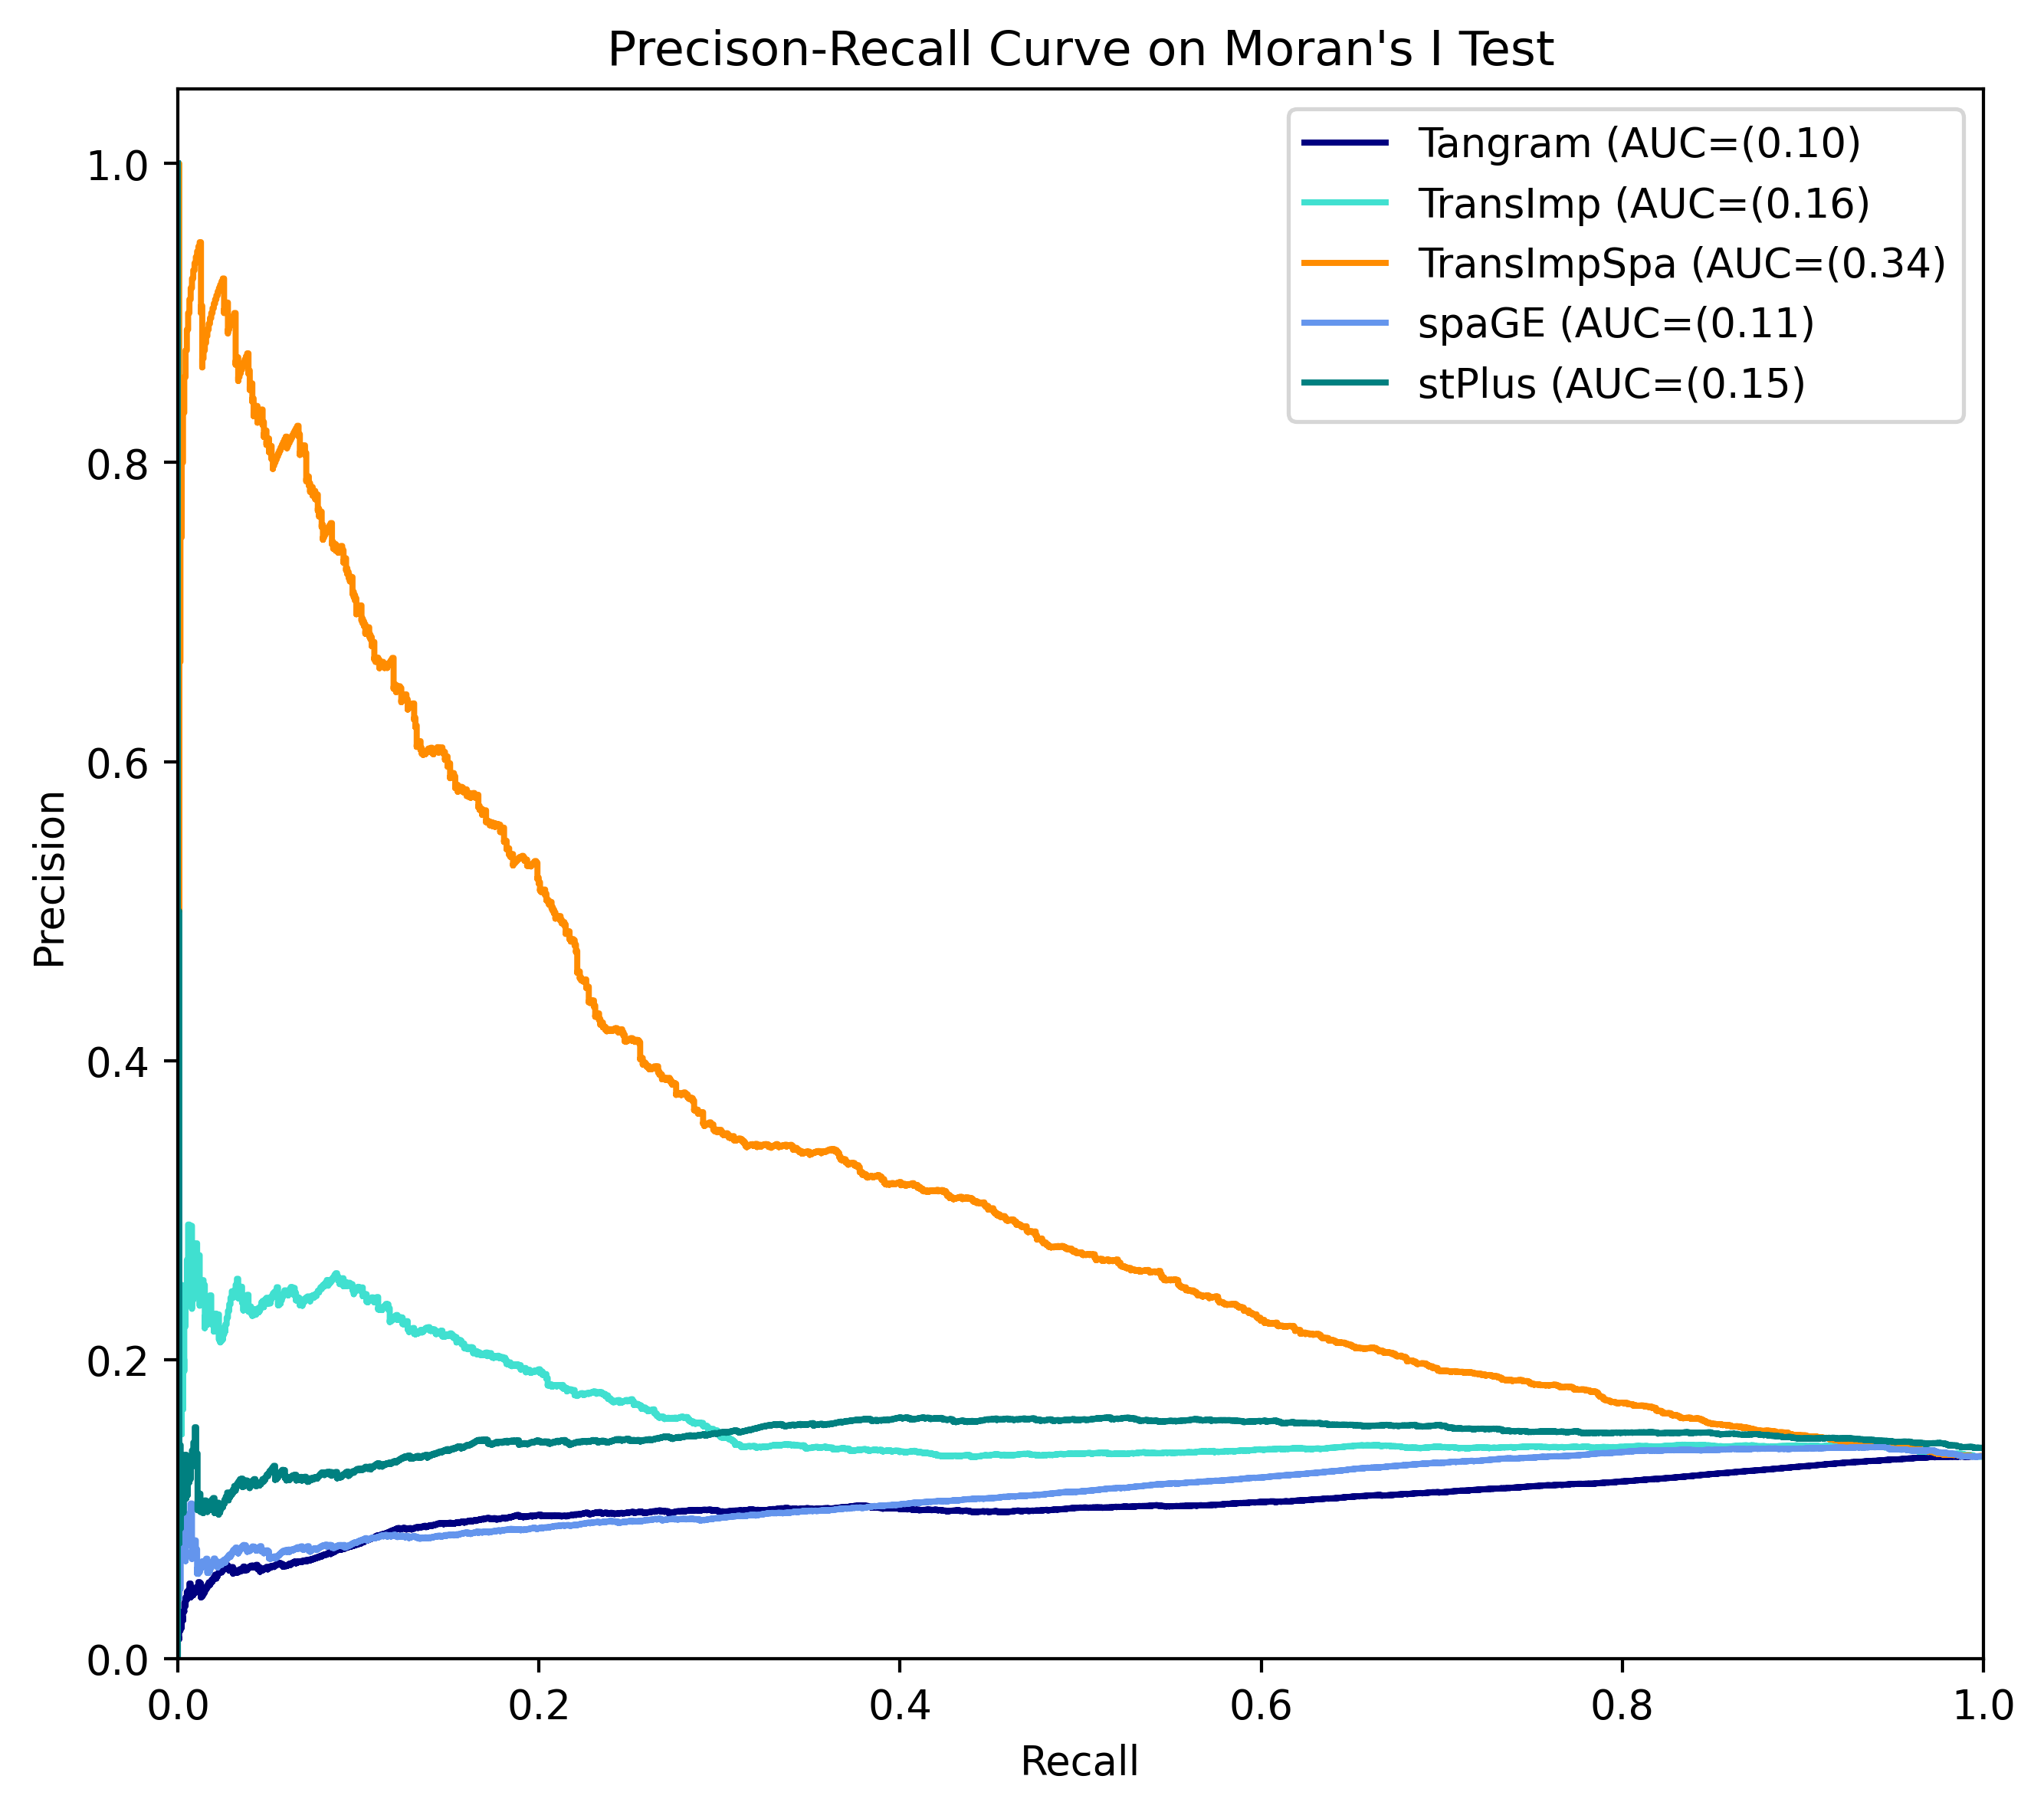

In [12]:
from sklearn import metrics
from matplotlib import pyplot as plt

idx = -1

plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa', 'truth'}: continue
    sel = (~np.isnan(df_I['truth'].values) ) & (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, preds_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
    score = df_I[method][sel]
    # score = -np.log(df_pval[method][sel] + min(df_pval[method][sel].min() * 1e-6, 1e-300))
    # score[np.isinf(score)] = score[~np.isinf(score)].max()*10
    print(np.isnan(preds_pval).sum())
    # plt.hist(fdr, bins=100)
    print(method)
    preds = preds_pval < thred
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}, Ground Sig/Total ({(truth_pval < thred).sum()}/{truth_pval.shape[0]}), Pred Sig/total ({(preds_pval < thred).sum()}/{preds_pval.shape[0]})')
    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpClsSpa", 'truth'}:
        idx += 1
    else:
        continue     
    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on Moran's I Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 10394/11365
Tangram
FPR: 0.998665
(TransImp) Valid genes: 10394/11365
TransImp
FPR: 0.966733
(TransImpSpa) Valid genes: 10394/11365
TransImpSpa
FPR: 0.652870
(spaGE) Valid genes: 10394/11365
spaGE
FPR: 0.970294
(stPlus) Valid genes: 9090/11365
stPlus
FPR: 0.000000


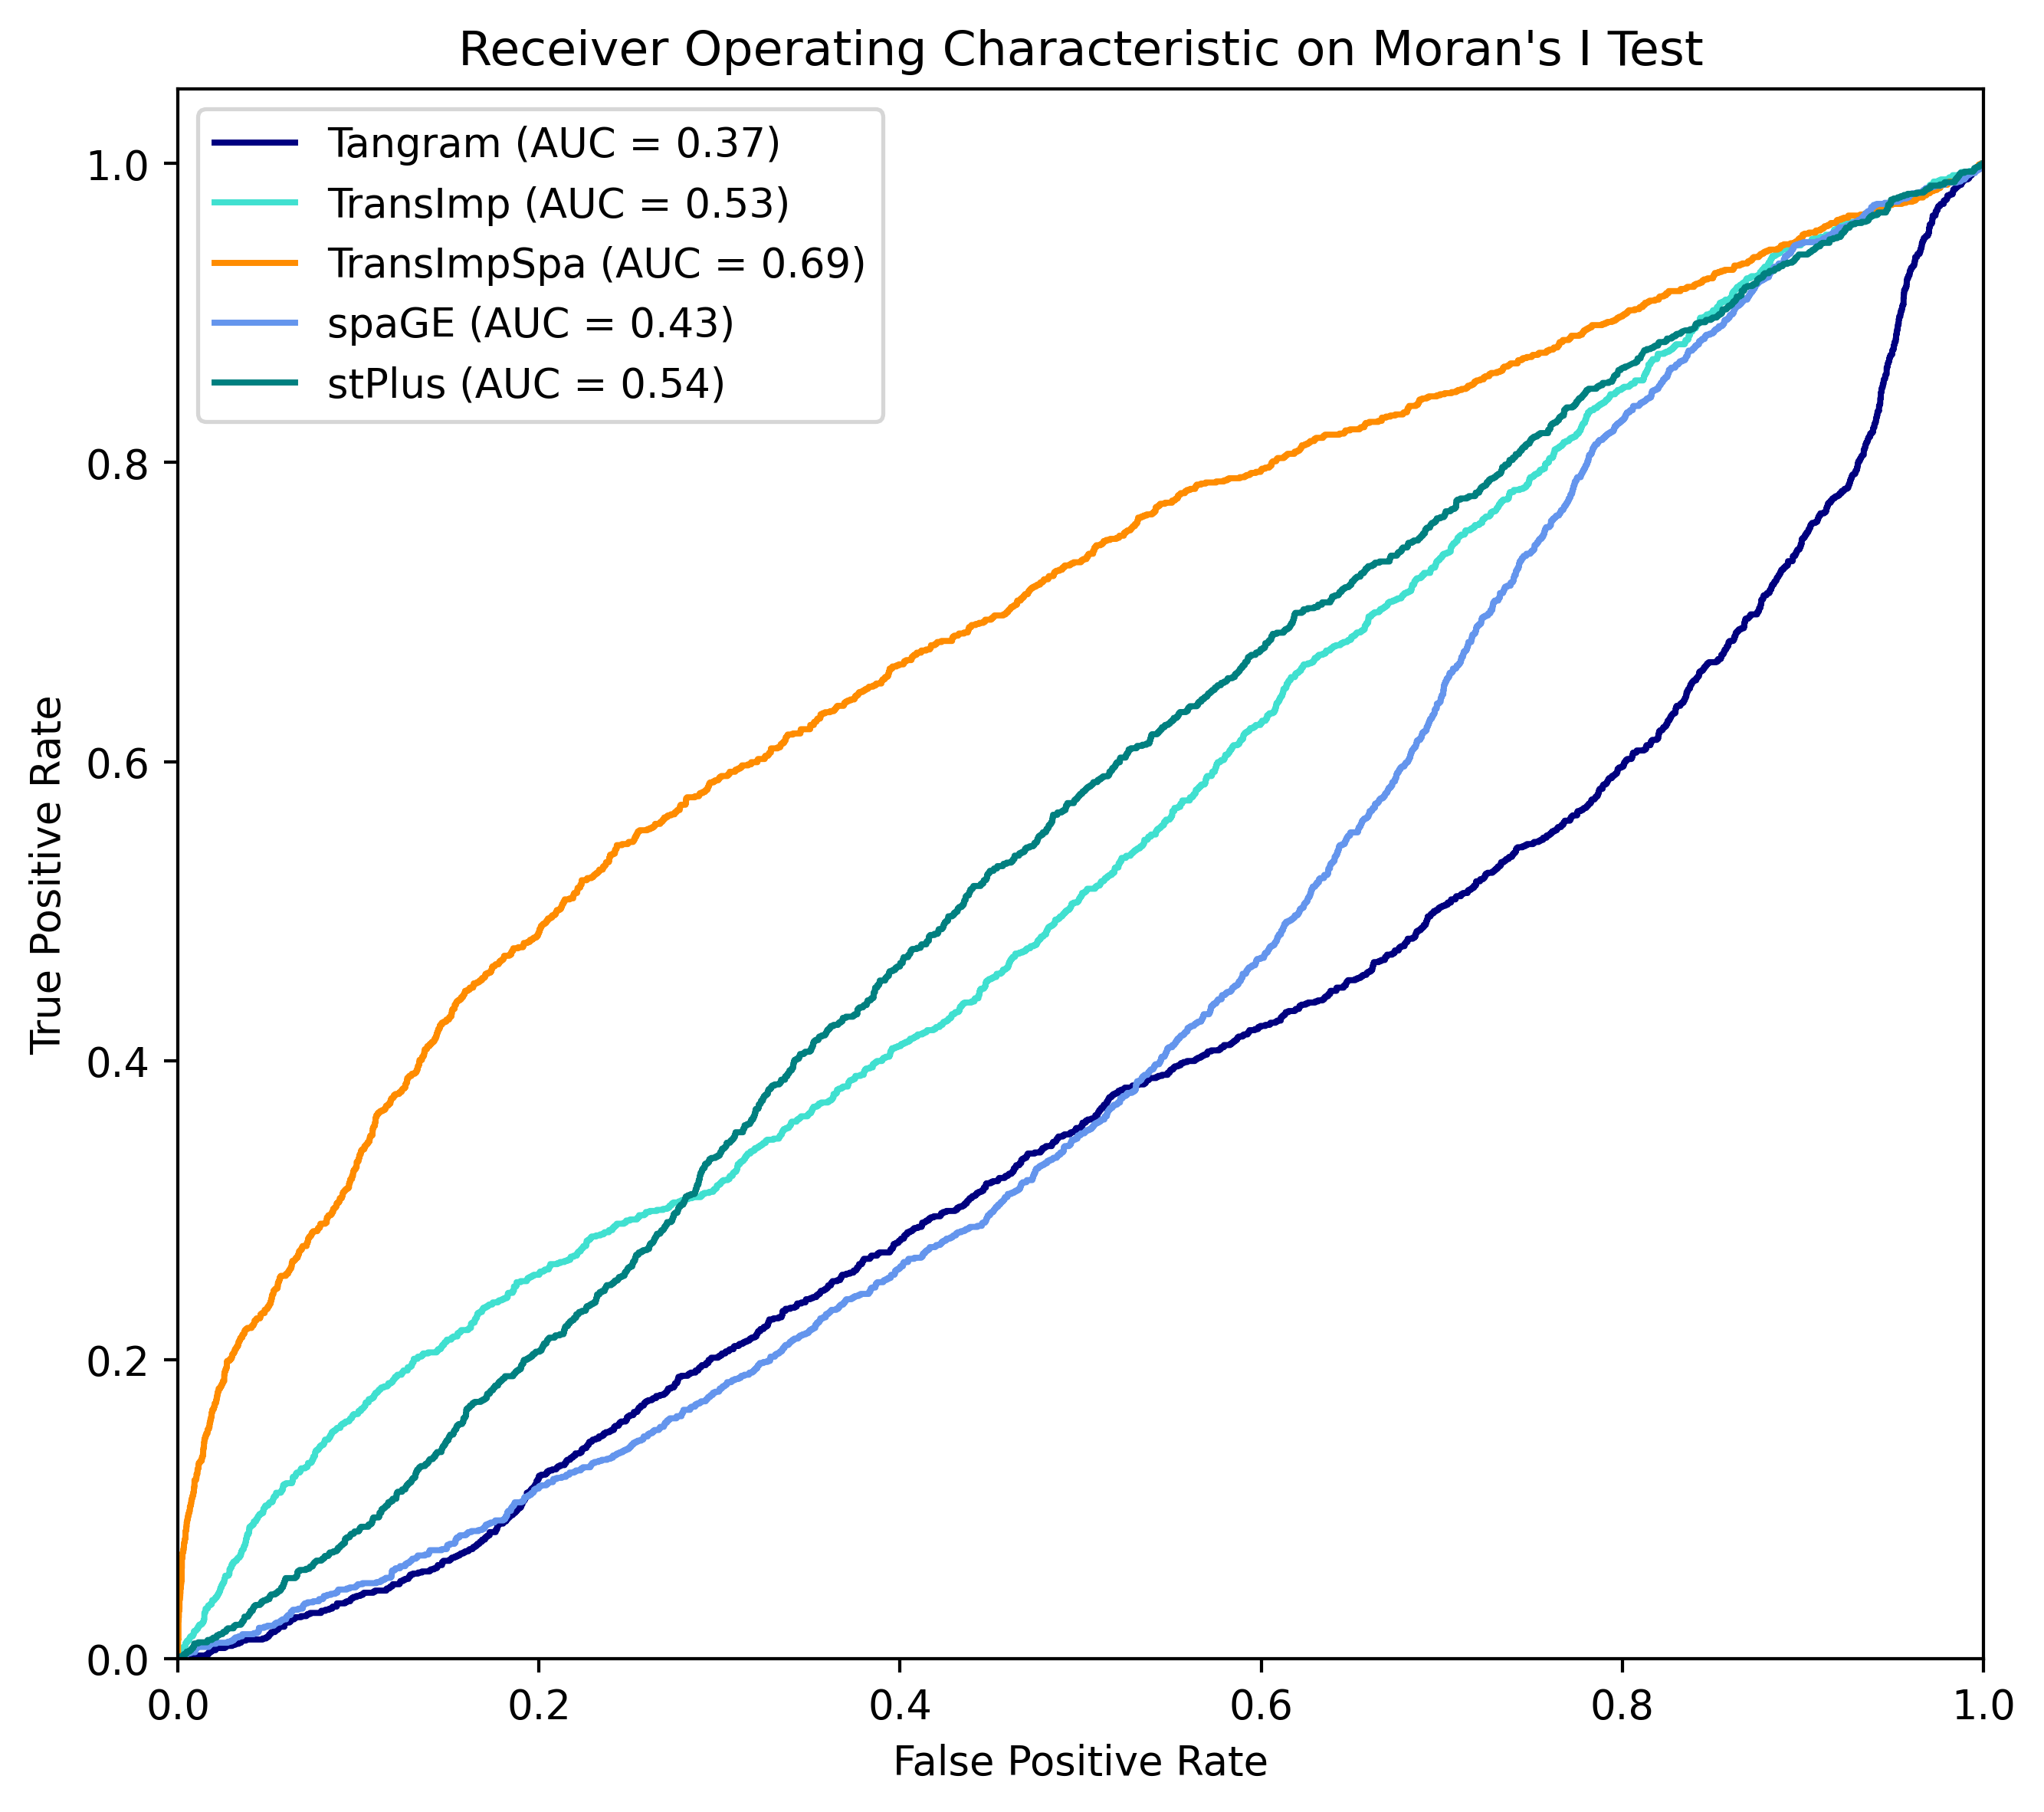

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

In [13]:
fprs = []
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue

    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0) 
    
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
    score = df_I[method][sel]
    # score = -np.log(df_pval[method][sel] + min(df_pval[method][sel].min() * 1e-6, 1e-300))
    # score[np.isinf(score)] = score[~np.isinf(score)].max()*10    
    print(method)
    preds = method_pval < thred
    
    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    
    if not method in {"transImpCls", 'truth',  "transImpClsSpa"}:
        fprs.append({"Method": method, 'False Positive Rate':cm[0][1]/(cm[0][1] + cm[0][0]), "Test": "Moran's I"})
        idx += 1
    else:
        continue
    
    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    plt.figure()
    lw = 2
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    disp.plot(ax=ax, name=f"{method} (AUC = {metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on Moran's I Test")
ax.legend(loc="best")
plt.show()


(Tangram) Valid genes: 10394/11365
Tangram
FPR: 0.998665
prec: 0.13442622950819672, recl: 0.9914651493598862,  F1: 0.23675271739130435
(TransImp) Valid genes: 10394/11365
TransImp
FPR: 0.966733
prec: 0.13722569754741337, recl: 0.9829302987197724,  F1: 0.24082948505707064
(TransImpSpa) Valid genes: 10394/11365
TransImpSpa
FPR: 0.652870
prec: 0.14009378663540445, recl: 0.6799431009957326,  F1: 0.23232077764277037
(spaGE) Valid genes: 10394/11365
spaGE
FPR: 0.970294
prec: 0.13704729863447457, recl: 0.9850640113798008,  F1: 0.24061848505906877
(stPlus) Valid genes: 9090/11365
stPlus
FPR: 0.000000
prec: 0.0, recl: 0.0,  F1: 0.0
(TransImpCls) Valid genes: 10394/11365
TransImpCls
FPR: 0.999110
prec: 0.13437439753229227, recl: 0.9914651493598862,  F1: 0.23667232597623086
(TransImpClsSpa) Valid genes: 10394/11365
TransImpClsSpa
FPR: 0.758011
prec: 0.1431266507357565, recl: 0.8093883357041252,  F1: 0.24324035481457734


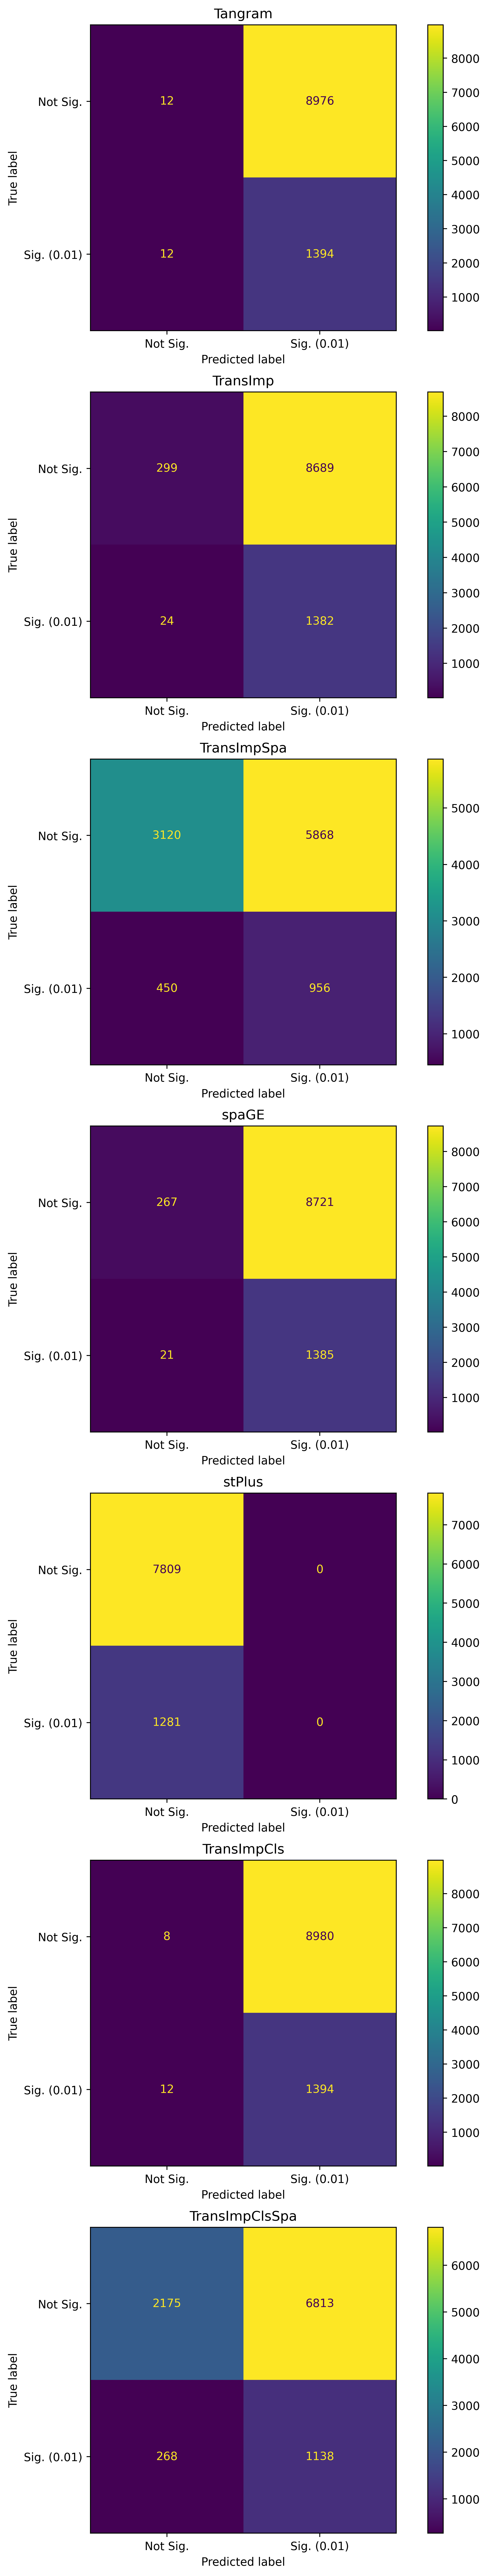

In [14]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in methods:
    # predict zero, 1-score
    if method == "truth": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    # else:
        # continue
    sel = (~np.isnan(df_I['truth'].values) ) & (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0) # & (df_issig.truth.values == 0)
    # sel = sel & (spa_adata[:, df_I.index.values].uns['moranI'].pval_norm_fdr_bh.values < thred)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, pred_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
    # score = df_I[method][sel]
    
    print(method)
    preds = pred_pval < thred
    # print("precision ", metrics.precision_score(y < thred, preds))
    # print("recall", metrics.recall_score(y < thred , preds))
    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

In [15]:
# !Rscript sparkX.r
!/mnt/chenqiao/nfs_share/software/anaconda3/envs/r-environment/bin/Rscript sparkX.r mouseliver5fold

[1] "truth"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 2110 
## number of total genes: 11365 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With Cosine Kernel 5
[1] "stPlus"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 2110 
## number of total genes: 9732 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing W

In [16]:
dict_sparkx_cmbpvals = {}
dict_sparkx_adjpvals = {}
ca_genes = None

for md in methods:
    print(md)
    df = pd.read_csv(f"../../output/sparkx_{ST_name}_{md}.csv", header=0, index_col=0)
    if ca_genes is None:
        ca_genes = df.index.values
    
    shared_gene = np.intersect1d(ca_genes, df.index.values)
    if len(shared_gene) < len(ca_genes):
        miss_gene  = np.setdiff1d(ca_genes, shared_gene)
        df = pd.concat([df, pd.DataFrame({"combinedPval":{g:1.0 for g in miss_gene},"adjustedPval":{g:1.0 for g in miss_gene} })], axis=0)
    dict_sparkx_cmbpvals[md] = df.loc[ca_genes, 'combinedPval']
    dict_sparkx_adjpvals[md] = df.loc[ca_genes, 'adjustedPval']
df_sparkx_cmbpvals = pd.DataFrame(dict_sparkx_cmbpvals)
df_sparkx_adjpvals = pd.DataFrame(dict_sparkx_adjpvals)
df_sparkx_cmbpvals, df_sparkx_adjpvals
    

truth
Tangram
TransImp
TransImpSpa
spaGE
stPlus
TransImpCls
TransImpClsSpa


(                        truth       Tangram      TransImp   TransImpSpa  \
 X0610005C13Rik   2.658968e-02  2.674469e-05  3.145237e-24  1.007638e-11   
 X0610010F05Rik   1.640302e-01  3.715596e-30  3.078557e-33  4.040535e-11   
 X0610010K14Rik   1.977146e-04  2.550680e-20  2.297602e-30  4.652435e-05   
 X0610012G03Rik   3.110786e-01  2.430504e-29  1.083615e-39  3.020695e-12   
 X0610030E20Rik   2.470698e-02  6.278046e-34  5.674269e-33  1.261213e-13   
 ...                       ...           ...           ...           ...   
 mt.Nd2          1.145121e-102  3.607427e-35  5.575361e-45  3.470207e-17   
 mt.Nd3           2.967465e-25  5.263366e-28  4.175562e-36  4.627410e-13   
 mt.Nd4           2.200623e-87  1.314146e-34  1.710992e-42  5.551115e-16   
 mt.Nd4l          1.176541e-06  1.941441e-30  1.660567e-41  2.553513e-15   
 mt.Nd5           1.670276e-18  1.977702e-36  1.188902e-43  1.732182e-16   
 
                        spaGE        stPlus   TransImpCls  TransImpClsSpa  
 X0610005C

(Tangram) Valid genes: 11365/11365
Tangram
FPR: 0.972269
(TransImp) Valid genes: 11365/11365
TransImp
FPR: 0.944352
(TransImpSpa) Valid genes: 11365/11365
TransImpSpa
FPR: 0.889445
(spaGE) Valid genes: 11365/11365
spaGE
FPR: 0.784177
(stPlus) Valid genes: 11365/11365
stPlus
FPR: 0.342052


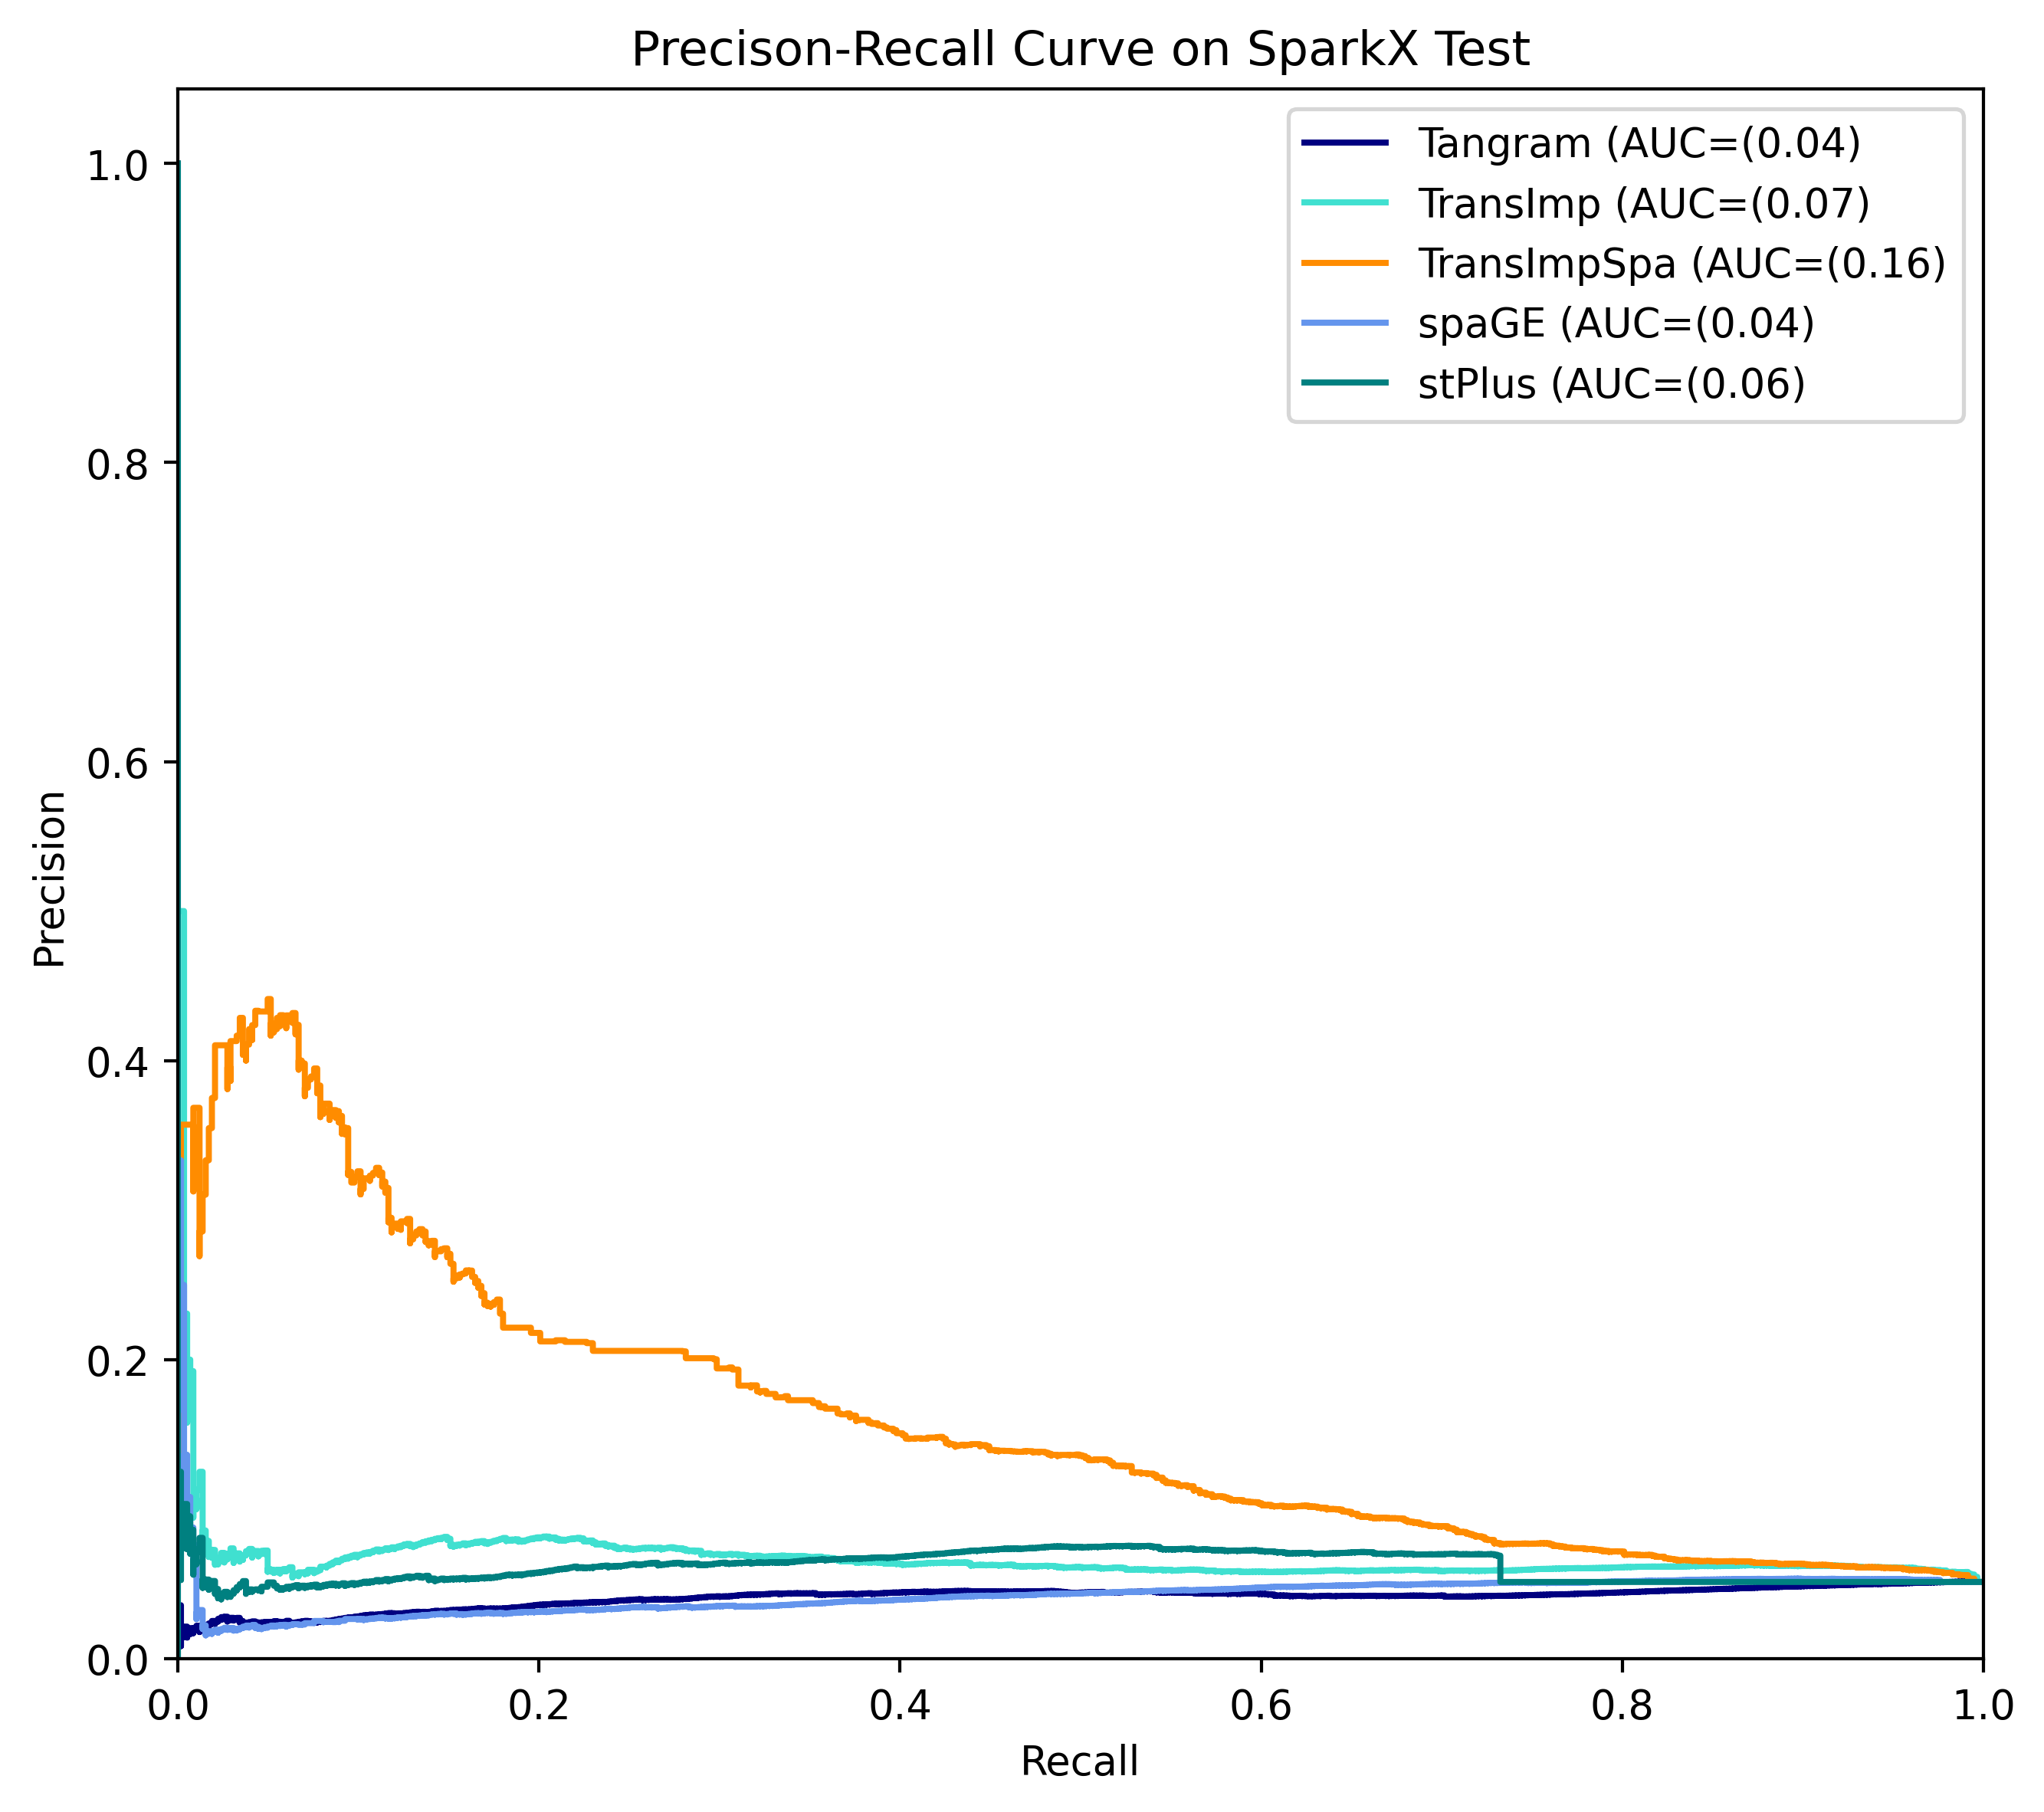

In [17]:
from sklearn import metrics
from matplotlib import pyplot as plt

thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue
    
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_cmbpvals[method][sel].values
    score = -np.log(df_sparkx_adjpvals[method][sel].values + min(np.min(df_sparkx_adjpvals[method][sel].values) * 1e-3, 1e-200))
    
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "truth", "transImpClsSpa"}:
        idx += 1
    else:
        continue      
    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
       
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 11365/11365
Tangram
FPR: 0.972269
(TransImp) Valid genes: 11365/11365
TransImp
FPR: 0.944352
(TransImpSpa) Valid genes: 11365/11365
TransImpSpa
FPR: 0.889445
(spaGE) Valid genes: 11365/11365
spaGE
FPR: 0.784177
(stPlus) Valid genes: 11365/11365
stPlus
FPR: 0.342052


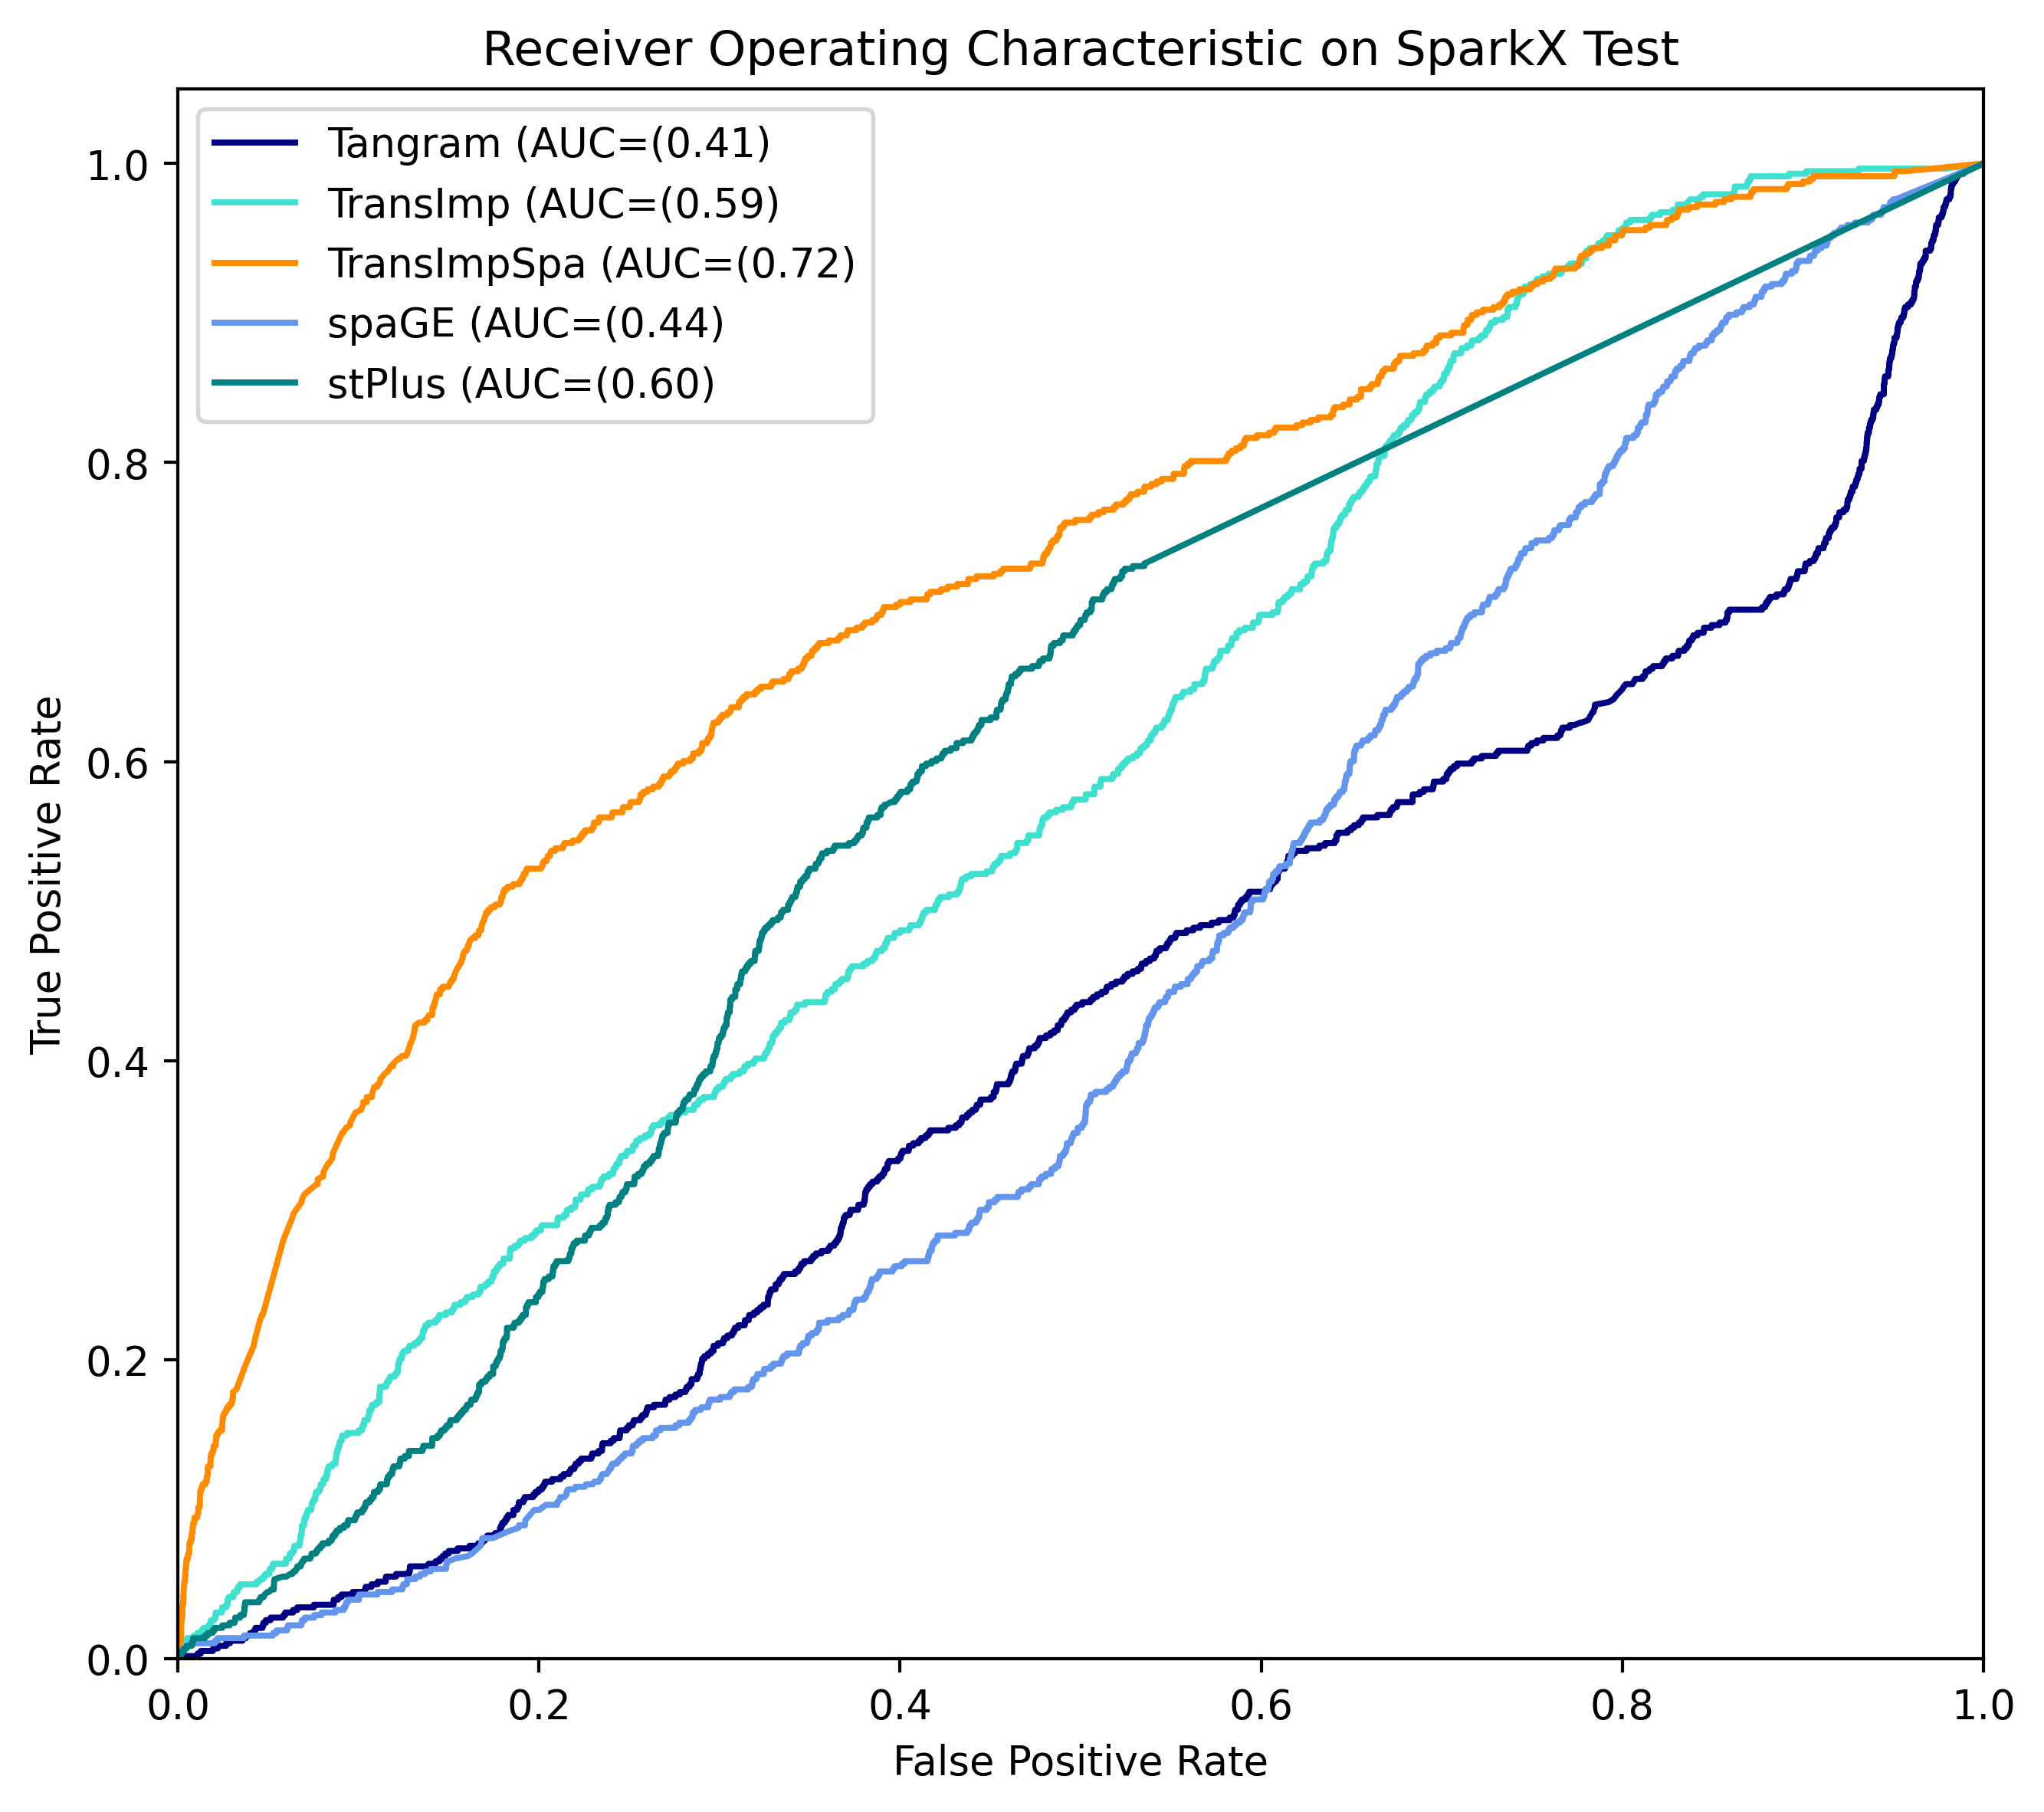

In [18]:
from sklearn import metrics
from matplotlib import pyplot as plt
thred = 0.01
idx = -1

plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_cmbpvals[method][sel].values
    score = -np.log(df_sparkx_adjpvals[method][sel].values + min(np.min(df_sparkx_adjpvals[method][sel].values) * 1e-3, 1e-200))
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "truth", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    
    auc_score = metrics.auc(fpr, tpr)
    
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 11365/11365
Tangram
FPR: 0.972269
prec: 0.05010873504893077, recl: 0.9485420240137221,  F1: 0.09518891470866683
(TransImp) Valid genes: 11365/11365
TransImp
FPR: 0.944352
prec: 0.05398123199851342, recl: 0.9965694682675815,  F1: 0.10241494799929489
(TransImpCls) Valid genes: 11365/11365
TransImpCls
FPR: 0.993693
prec: 0.051522662889518414, recl: 0.9982847341337907,  F1: 0.09798804613182929
(TransImpClsSpa) Valid genes: 11365/11365
TransImpClsSpa
FPR: 0.960397
prec: 0.05278082693011343, recl: 0.9897084048027445,  F1: 0.10021710811984369
(TransImpSpa) Valid genes: 11365/11365
TransImpSpa
FPR: 0.889445
prec: 0.05638098986519728, recl: 0.9828473413379074,  F1: 0.10664433277498603
(spaGE) Valid genes: 11365/11365
spaGE
FPR: 0.784177
prec: 0.05085316569375842, recl: 0.7770154373927959,  F1: 0.09545885575808662
(stPlus) Valid genes: 11365/11365
stPlus
FPR: 0.342052
prec: 0.07476166583040643, recl: 0.5111492281303602,  F1: 0.130444298533596


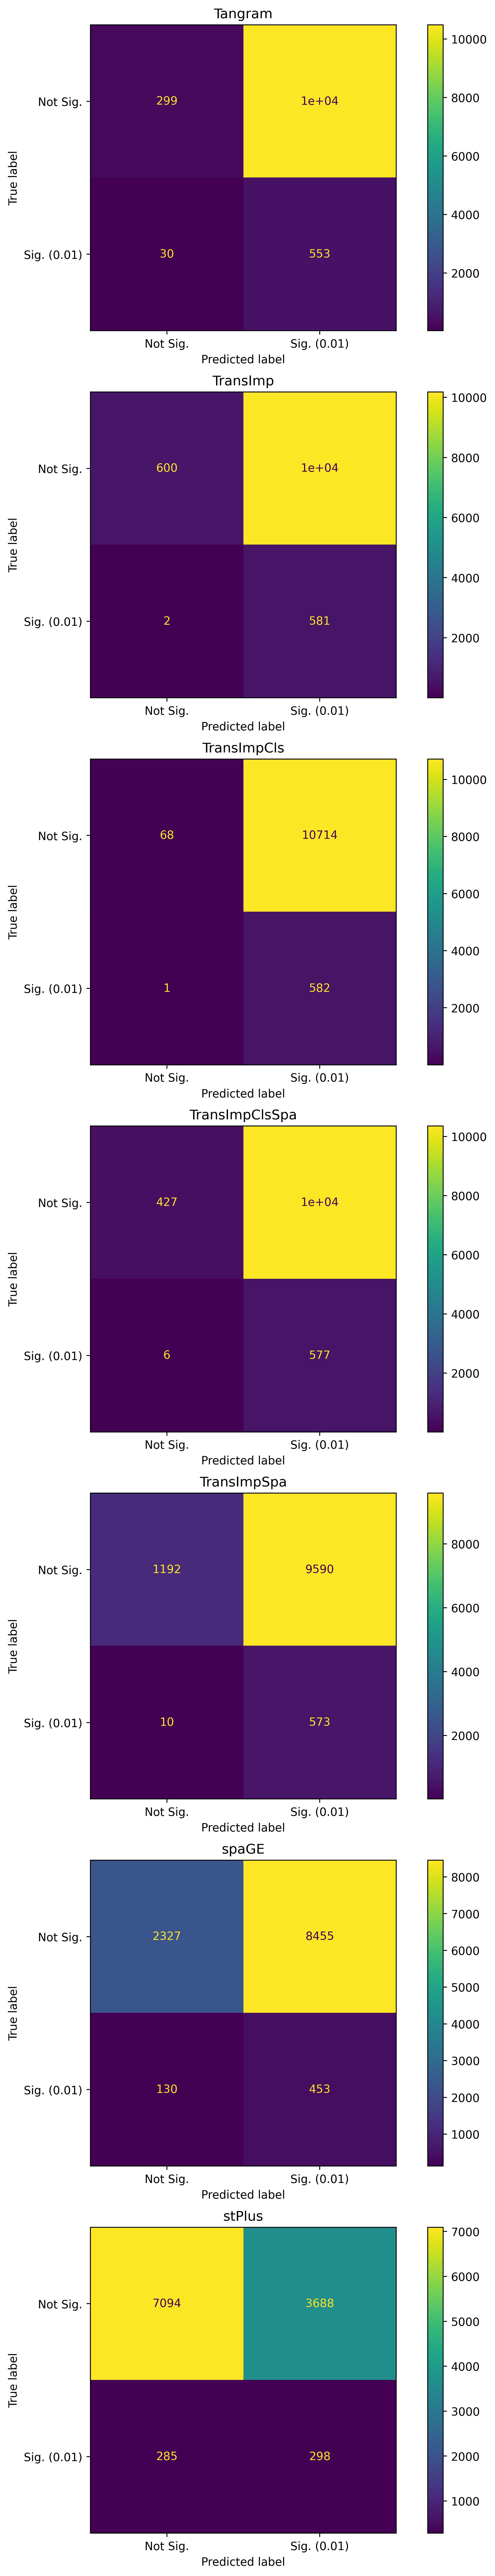

In [19]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method == "truth": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

In [20]:
from scipy import sparse
def merge_data(imp_adata, adata):
    valid_genes = [g for g in adata.var_names if g not in imp_adata.var_names]
    print(f"Valid genes: {len(valid_genes)}, Ex genes: {imp_adata.shape[1]}")
    X = adata[:, valid_genes].X
    if sparse.issparse(X):
        X = X.toarray()
    X = np.hstack([X, imp_adata.X])
    m_adata = sc.AnnData(X, dtype=np.float32)
    m_adata.var_names = np.concatenate([valid_genes, imp_adata.var_names.values])
    return m_adata
def read_data(imp_adatas):
    sc.read_csv(f"../../data/ST/MouseLiver/SCP2046/expression/processed_c1.csv.gz").T.copy()
    adatas = {}
    for method in methods:
        adatas[method] = merge_data(imp_adatas[method], spa_adata)
        adatas[method].obsm['spatial'] = spa_adata.obsm['spatial'].copy()
    return adatas

m_adatas = read_data(dict_adata)

Valid genes: 942, Ex genes: 11365
Valid genes: 942, Ex genes: 11365
Valid genes: 942, Ex genes: 11365
Valid genes: 942, Ex genes: 11365
Valid genes: 942, Ex genes: 11365
Valid genes: 942, Ex genes: 11365
Valid genes: 942, Ex genes: 11365
Valid genes: 942, Ex genes: 11365


In [21]:
def spatialdm(adata, spec, l):
    sdm.weight_matrix(adata, n_nearest_neighbors=6, l=l, cutoff=0.2, single_cell=False)
    # find overlapping LRs from CellChatDB
    sdm.extract_lr(adata, spec, min_cell=0)
    # global Moran selection
    # print(adata.uns)
    # print(adata)
    cp_adata = None
    try:
        sdm.spatialdm_global(adata, 10, specified_ind=None, method='both', nproc=10)
        sdm.sig_pairs(adata, method='z-score', fdr=True, threshold=0.1)        
    except Exception as e:
        # print(e)
        cp_adata = adata.copy()
        sdm.extract_lr(cp_adata, spec, min_cell=1)
        sdm.spatialdm_global(cp_adata, 10, specified_ind=None, method='both', nproc=10)
        sdm.sig_pairs(cp_adata, method='z-score', fdr=True, threshold=0.1)
    # select significant pairs
    if not cp_adata is None:
        full_set = adata.uns['geneInter'].interaction_name
        # print(np.intersect1d(full_set, cp_adata.uns['global_res'].index.values))
        full_global_res = cp_adata.uns['global_res'].copy()
        full_global_res['global_I'] = cp_adata.uns['global_I'].copy()
        for pair in full_set:
            if pair not in cp_adata.uns['global_res'].index.values:
                # z	perm_pval	fdr	selected
                full_global_res = pd.concat([full_global_res, pd.DataFrame({
                    "Ligand0":{pair:pair.split("_")[0]},
                    "Receptor0":{pair:pair.split("_")[1]},
                    "Receptor1":{pair:None},
                    "z_pval":{pair:0.99 + np.random.rand() * 0.01},
                    "z":{pair:np.random.rand()*0.01},
                    "perm_pval":{pair:0.99 + np.random.rand() * 0.01},
                    "fdr":{pair:0.99 + np.random.rand() * 0.01},
                    "selected":{pair:False},
                    "global_I":{pair:np.random.rand() * 1e-6},
                })])
        # print(np.intersect1d(full_global_res.index, cp_adata.uns['global_res'].index.values))        
        adata.uns['global_res'] = full_global_res.loc[adata.uns['geneInter'].interaction_name].copy()
        adata.uns['global_I'] = full_global_res.global_I.values
        
        
    valid_genes = [True if l != r else False for l,r in zip(adata.uns['global_res'].Ligand0, adata.uns['global_res'].Receptor0)]
    print(len(valid_genes), adata.uns['global_res'].shape[0])
    sel = adata.uns['global_res'].index[valid_genes]
    adata.uns['global_res'] = adata.uns['global_res'].loc[sel]
    adata.uns['global_I'] = adata.uns['global_I'][valid_genes]
    adata.uns['global_res'].sort_values(by='fdr')
    print(adata.uns['global_res'].shape)
for md in m_adatas:
    spatialdm(m_adatas[md], spec, 20)    

100%|██████████| 10/10 [00:00<00:00, 20.03it/s]


816 816
(800, 11)


100%|██████████| 10/10 [00:00<00:00, 20.41it/s]


816 816
(800, 11)


100%|██████████| 10/10 [00:00<00:00, 20.90it/s]


816 816
(800, 11)


100%|██████████| 10/10 [00:00<00:00, 20.63it/s]


816 816
(800, 11)


100%|██████████| 10/10 [00:00<00:00, 21.73it/s]


816 816
(800, 11)


100%|██████████| 10/10 [00:00<00:00, 32.78it/s]


816 816
(800, 11)


100%|██████████| 10/10 [00:00<00:00, 20.46it/s]


816 816
(800, 11)


100%|██████████| 10/10 [00:00<00:00, 21.05it/s]

816 816
(800, 11)


In [22]:
import pickle
with open(f"../../output/{ST_name}_spatialdm.pkl", 'wb') as outfile:
    pickle.dump(m_adatas, outfile)

Tangram # 649 pairs, # sig pairs: (Truth): 43, (Preds) 256
TransImp # 649 pairs, # sig pairs: (Truth): 43, (Preds) 257
TransImpSpa # 649 pairs, # sig pairs: (Truth): 43, (Preds) 252
spaGE # 649 pairs, # sig pairs: (Truth): 43, (Preds) 223
stPlus # 649 pairs, # sig pairs: (Truth): 43, (Preds) 108
TransImpCls # 649 pairs, # sig pairs: (Truth): 43, (Preds) 242
TransImpClsSpa # 649 pairs, # sig pairs: (Truth): 43, (Preds) 230


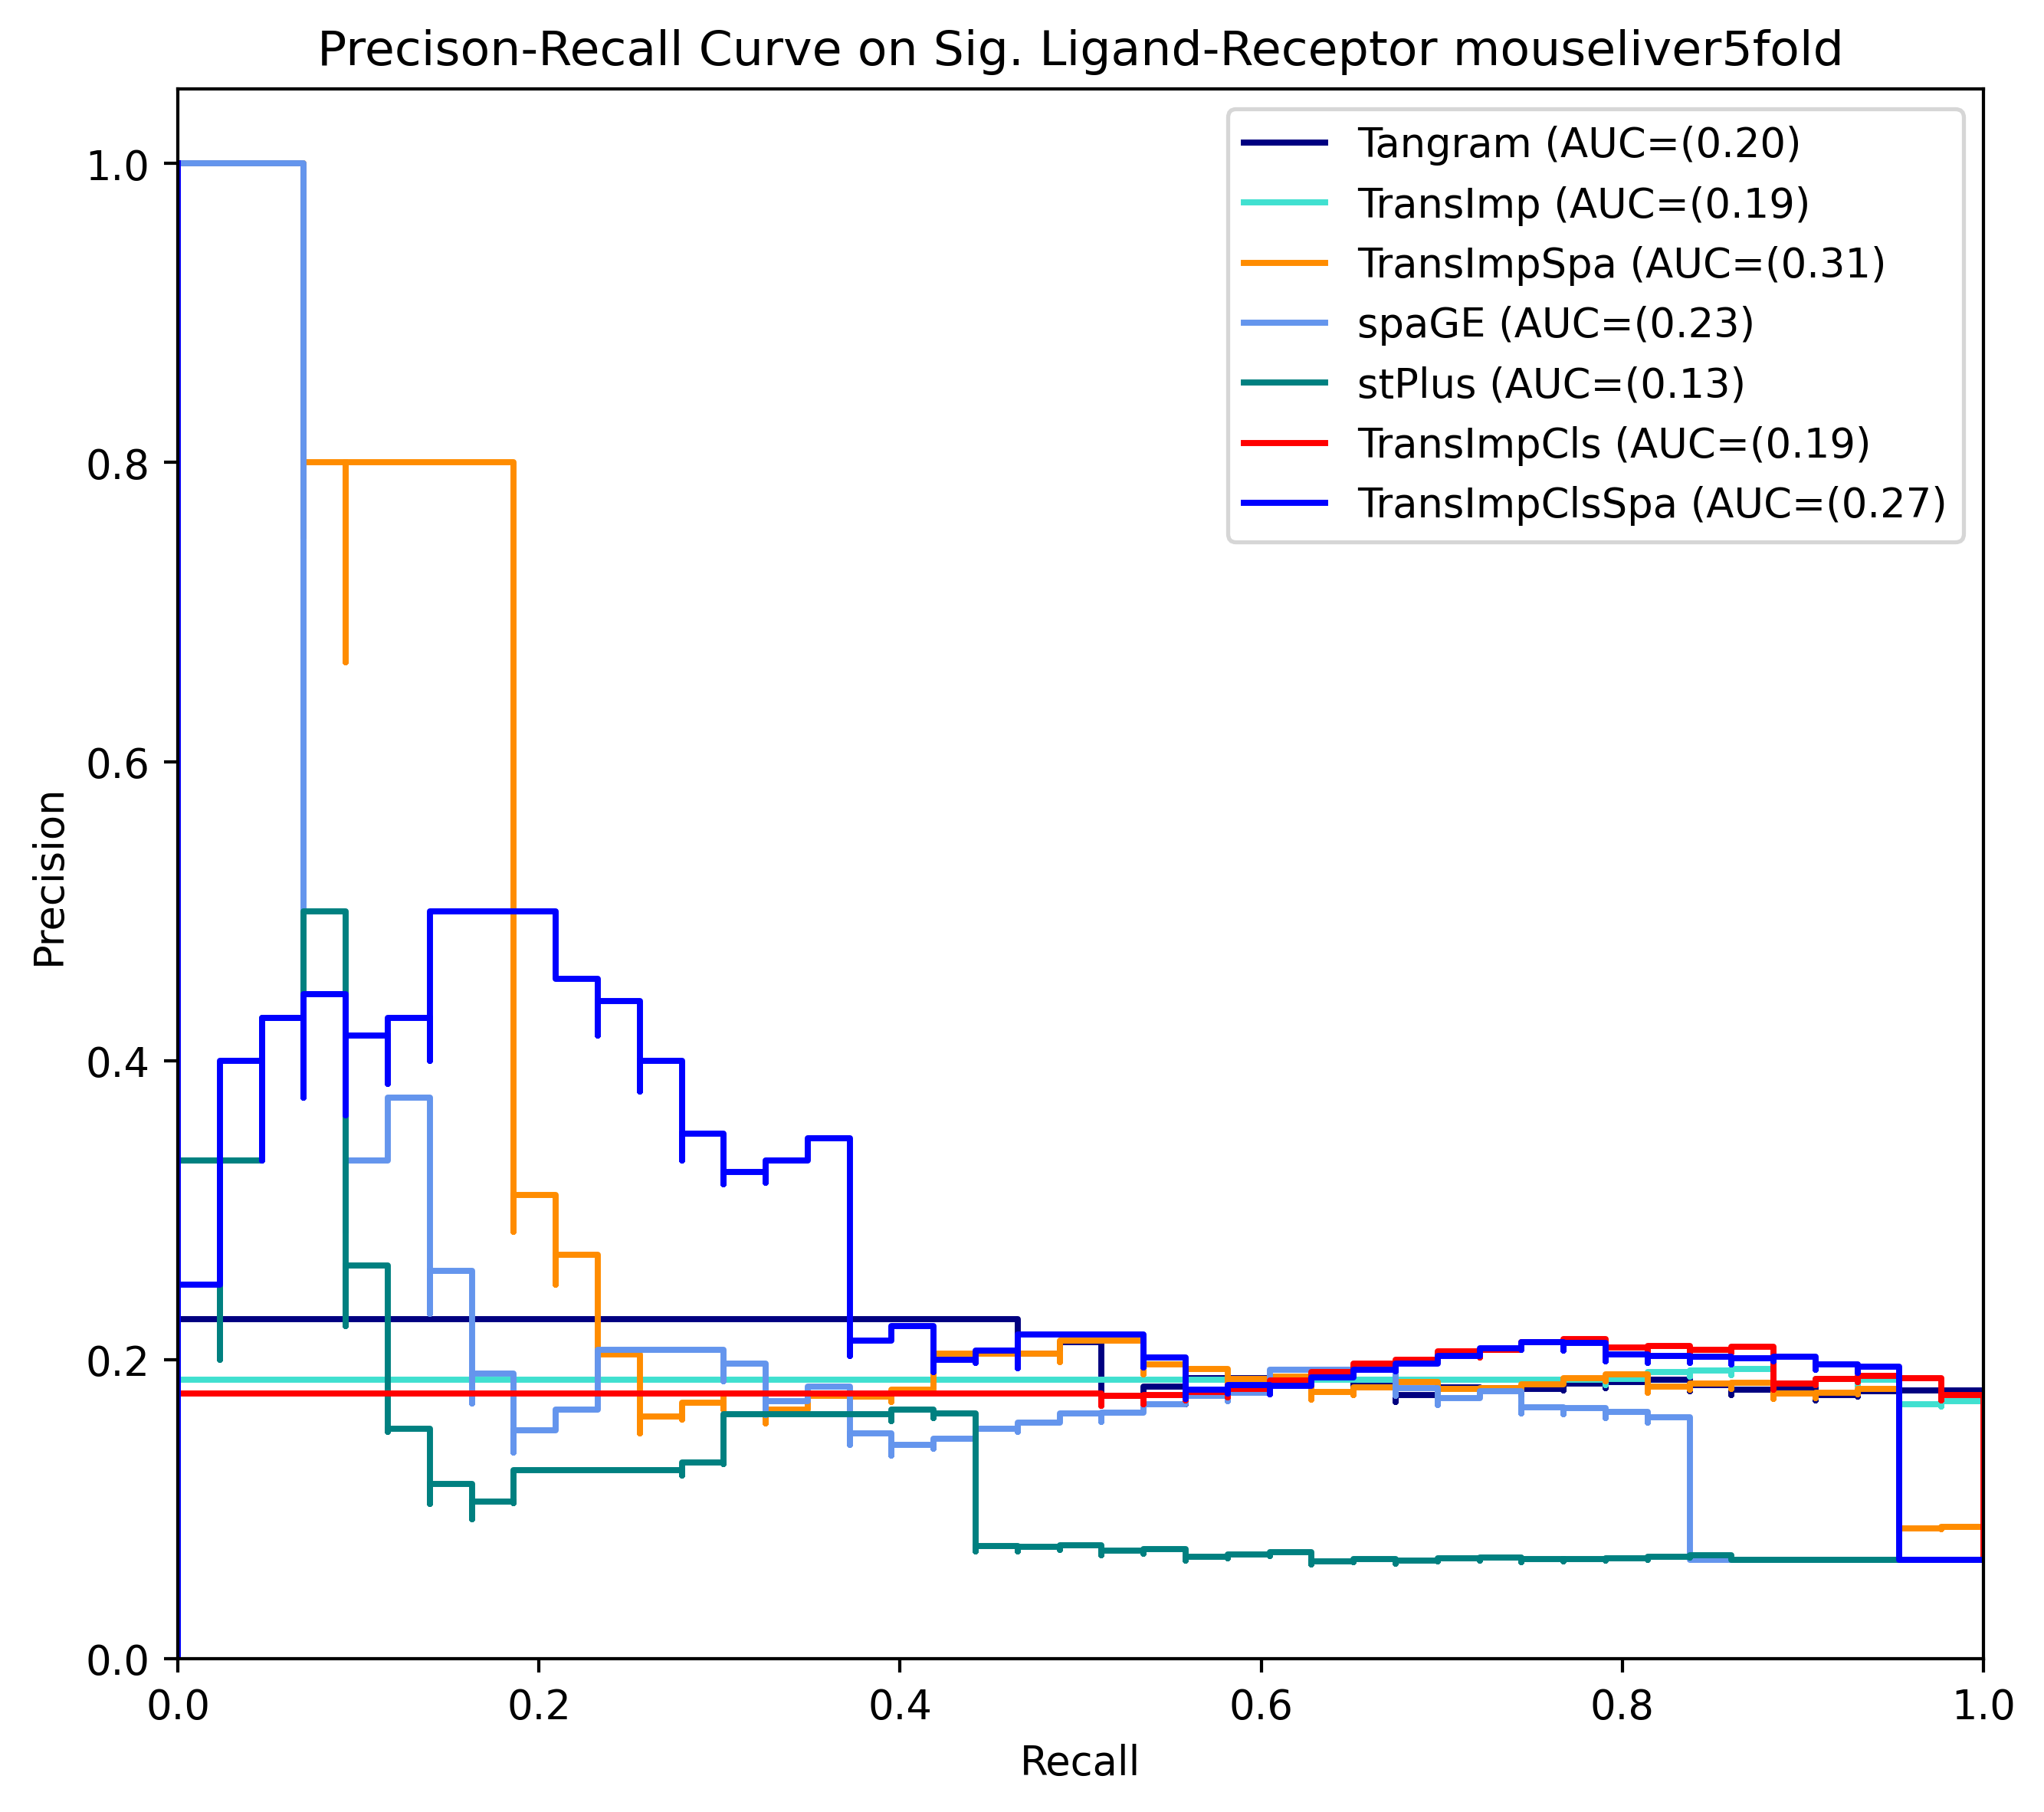

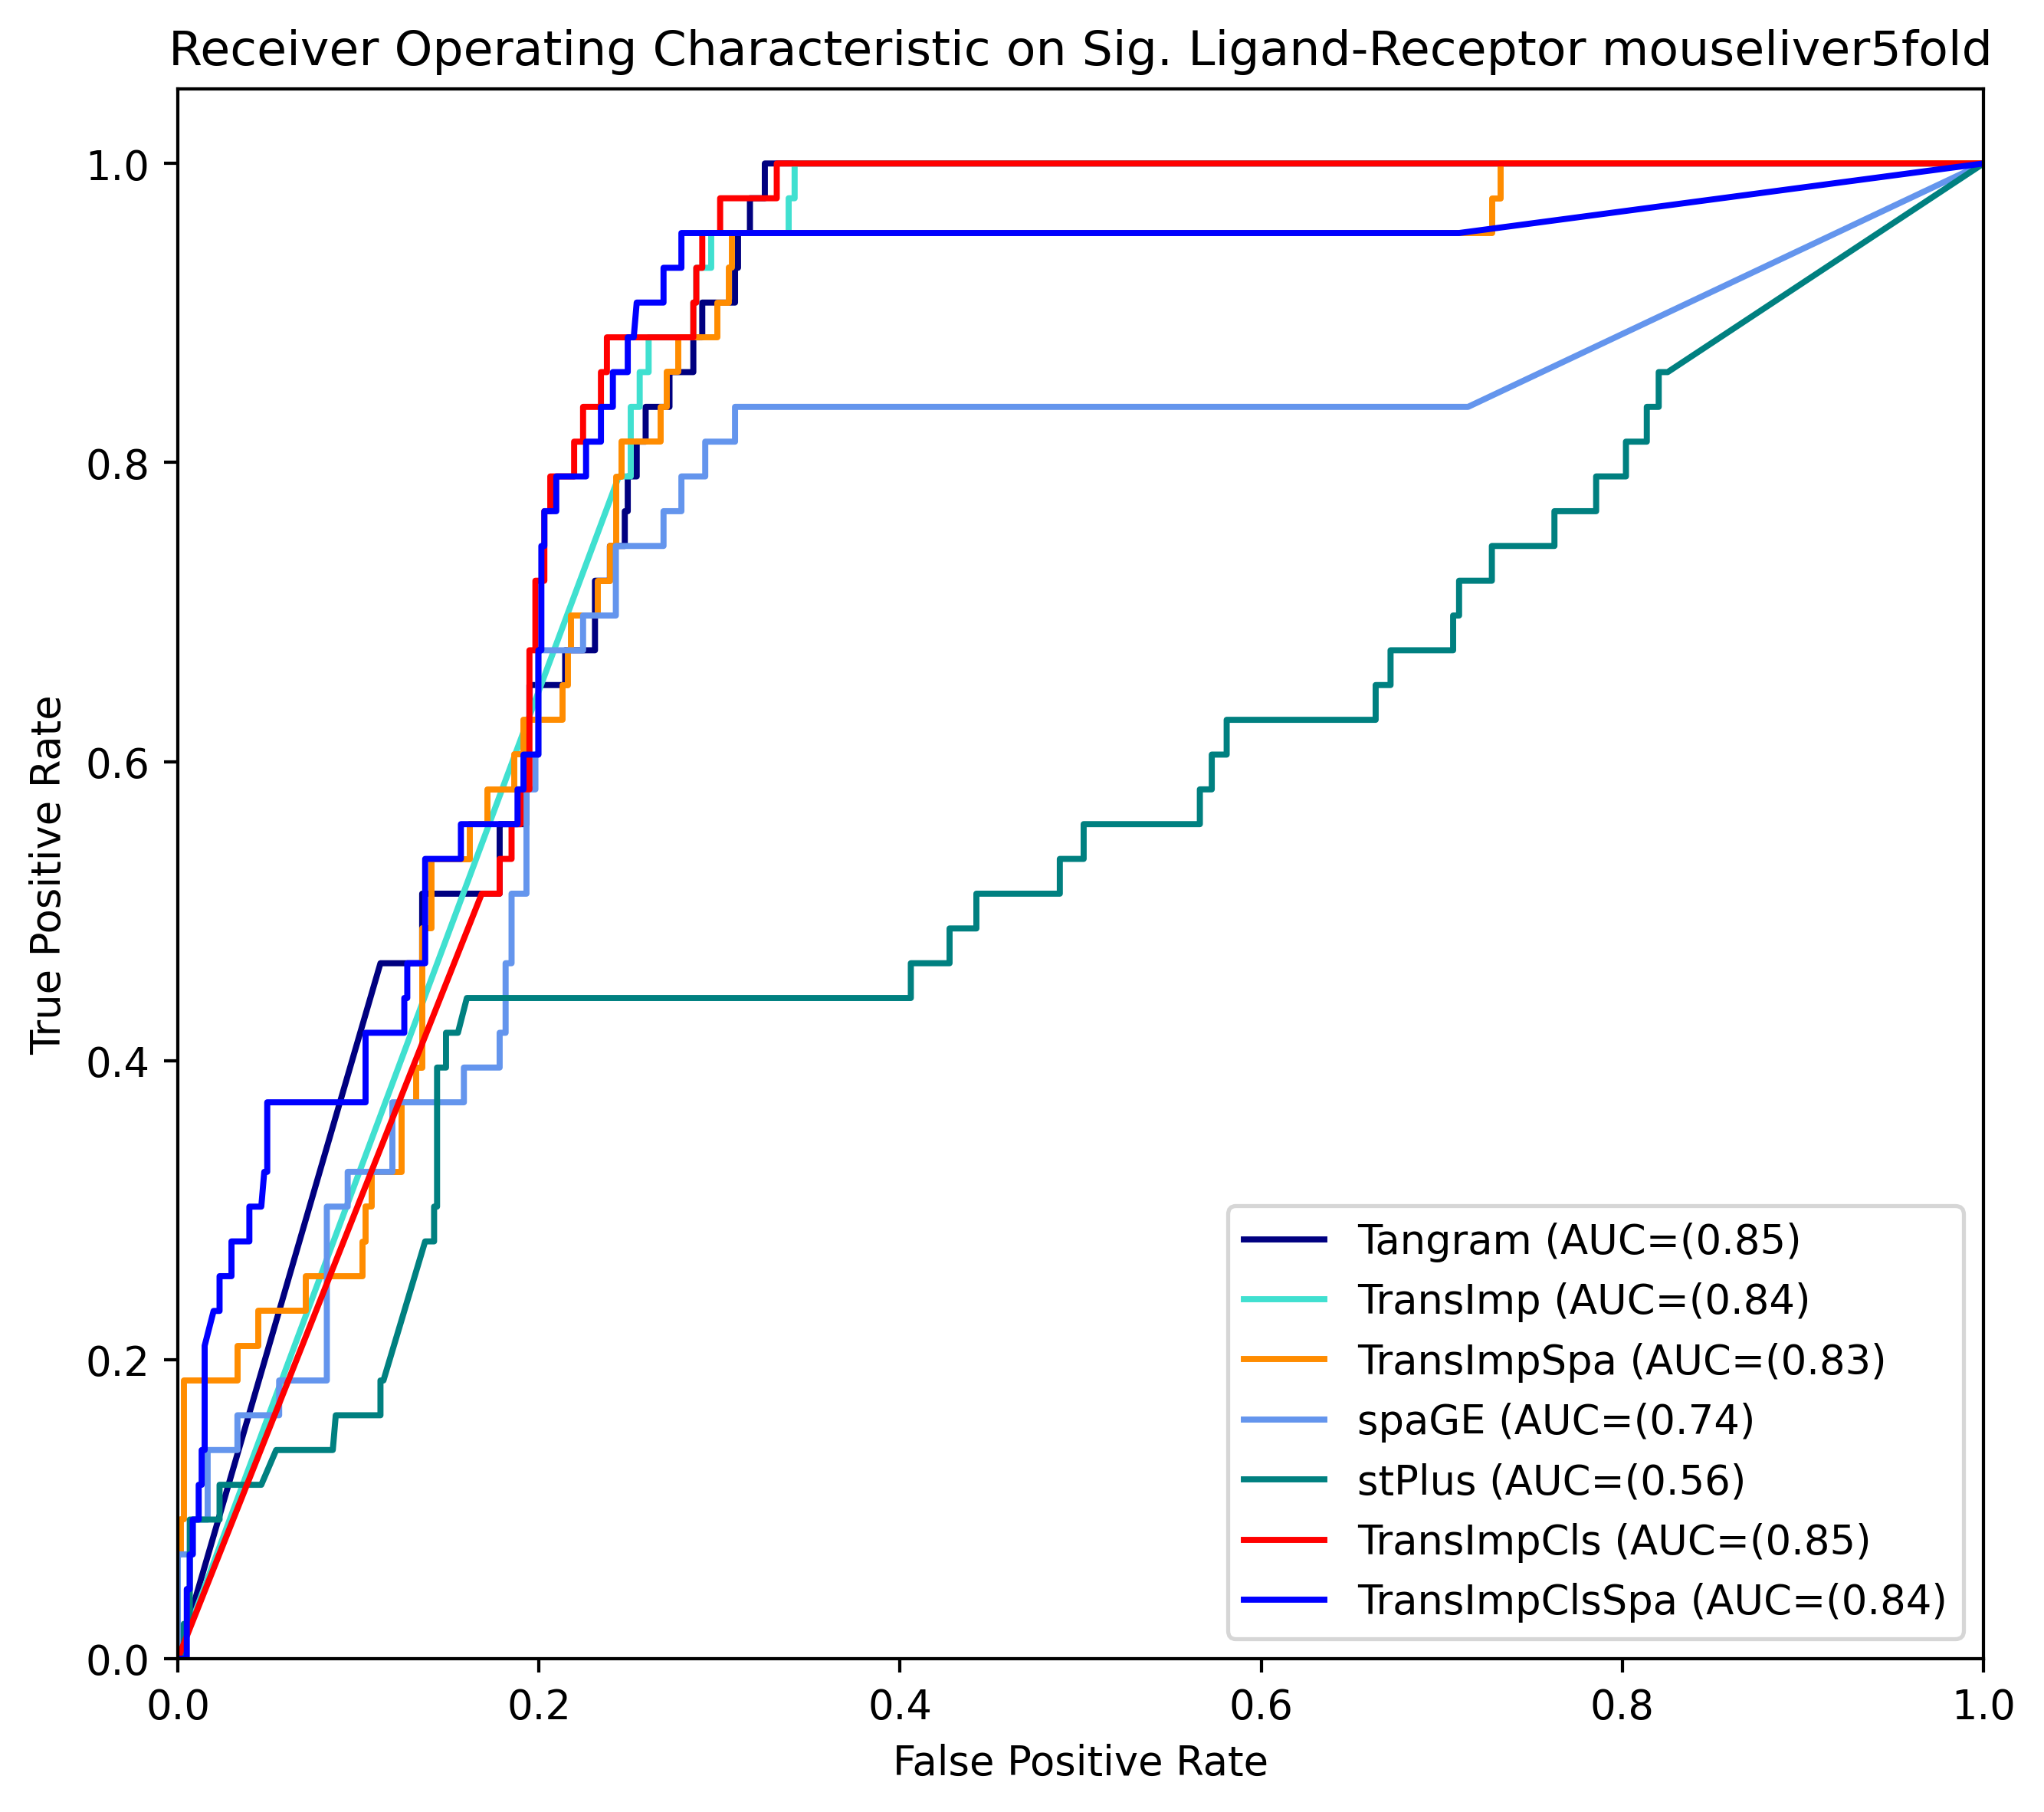

In [23]:
def precision_recall_curve(adatas, dataset_name):
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in methods:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        print(f"{md} # {len(genes)} pairs, # sig pairs: (Truth): {truth_res.loc[genes].selected.values.sum()}, (Preds) {adatas[md].uns['global_res'].loc[genes].selected.values.sum()}")
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        # print(adatas[md].uns['global_res'].loc[genes].fdr.values)
        # print(np.max(adatas[md].uns['global_res'].loc[genes].fdr.values), np.min(adatas[md].uns['global_res'].loc[genes].fdr.values))
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + min(np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # new_scores = list(range(len(score)))
        # score = np.array([new_scores[idx] for idx in np.argsort(score)])
        # plt.hist(score, bins=100);plt.show()
        # score = expit(score)
        # plt.hist(score, bins=100)
        # plt.show()
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        
        prec, rec, thresholds  = metrics.precision_recall_curve(y, score, pos_label=1)
        
        disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.average_precision_score(y, score):.2f})", color=color[idx])
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Precison-Recall Curve on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()   
    
def roc_curve(adatas, dataset_name):     
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in methods:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        # print(np.max(adatas[md].uns['global_res'].loc[genes].fdr.values), np.min(adatas[md].uns['global_res'].loc[genes].fdr.values))
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + min(np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # new_scores = list(range(len(score)))
        # score = np.array([new_scores[idx] for idx in np.argsort(score)])
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # score = expit(score)
        fpr, tpr, thresholds  = metrics.roc_curve(y, score, pos_label=1)
        
        auc_score = metrics.auc(fpr, tpr)
        
        disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
        
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.roc_auc_score(y, score):.2f})", color=color[idx])
        
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Receiver Operating Characteristic on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()
    

precision_recall_curve(m_adatas, ST_name)
roc_curve(m_adatas, ST_name)
